# IoBT Moving Object Detection - Data Exploration and Analysis

## Seismic and Acoustic Data Summary Statistics

This notebook performs initial data exploration and statistical analysis of seismic (EHZ) and acoustic (AUD16000) sensor data collected from various vehicle movement experiments.

**Dataset Overview:**
- **Seismic Data (ehz.csv)**: Vertical component seismometer readings
- **Acoustic Data (aud16000.csv)**: Audio recordings at 16 kHz sampling rate (stored via Git LFS)
- **GPS Data (gps.csv)**: Vehicle position tracking
- **Vehicle Types**: Polaris, Silverado, Warhog
- **Conditions**: Line of sight and no line of sight scenarios

**⚠️ Note for Git Users:** Large audio files are managed with Git LFS. After cloning, run `git lfs pull` to download all data files.

## 1. Import Required Libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path
from scipy import stats  # Used for skewness and kurtosis calculations

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 3.0.0
NumPy version: 2.4.1


## 2. Define Data Directory and Explore Structure

In [79]:
# Define the base data directory
# GitHub Repository: https://github.com/antoniogmagana/Dark_Circle.git
# 
# SETUP INSTRUCTIONS FOR USERS:
# 1. Clone the repository: git clone https://github.com/antoniogmagana/Dark_Circle.git
# 2. Place your data in: Dark_Circle/raw_data/
# 3. Expected structure:
#    Dark_Circle/
#    ├── Data exploration.ipynb (this notebook)
#    └── raw_data/
#        ├── Polaris0150pm/
#        ├── Polaris0215pm/
#        ├── Silverado0255pm/
#        └── ... (other experiment folders)

# Get the directory where this notebook is located
notebook_dir = Path.cwd()  # Default to current working directory

try:
    # Try to get notebook path from ipython (available in Jupyter environments)
    ipython = get_ipython()  # type: ignore
    if ipython is not None:
        notebook_file = ipython.user_ns.get('__vsc_ipynb_file__', '')
        if notebook_file:
            notebook_path = Path(notebook_file)
            if notebook_path.exists():
                notebook_dir = notebook_path.parent
except (NameError, AttributeError):
    # Not in a Jupyter environment or get_ipython not available
    pass

# Expected structure: raw_data should be in same directory as notebook
base_dir = notebook_dir / 'raw_data'

# Allow override via environment variable
if 'DATA_DIR' in os.environ:
    base_dir = Path(os.environ['DATA_DIR'])

print(f"📁 Notebook directory: {notebook_dir}")
print(f"📁 Data directory: {base_dir}")
print(f"📍 Directory exists: {base_dir.exists()}")

if not base_dir.exists():
    print(f"\n⚠️  Data directory not found!")
    print(f"\n💡 Setup Instructions:")
    print(f"   1. Clone repository: git clone https://github.com/antoniogmagana/Dark_Circle.git")
    print(f"   2. Move this notebook to: Dark_Circle/")
    print(f"   3. Create directory: Dark_Circle/raw_data/")
    print(f"   4. Place your experiment folders in: Dark_Circle/raw_data/")
    print(f"\n   Or set DATA_DIR environment variable to point to your data location.")
print()

# List all experiment folders (only if directory exists)
experiment_folders = []
if base_dir.exists():
    experiment_folders = [f.name for f in base_dir.iterdir() if f.is_dir()]
    experiment_folders.sort()

print("=" * 70)
print("AVAILABLE EXPERIMENT FOLDERS")
print("=" * 70)

if experiment_folders:
    for i, folder in enumerate(experiment_folders, 1):
        folder_path = base_dir / folder
        rs1_path = folder_path / 'rs1'
        
        # Filter out system files like .DS_Store
        files = []
        if rs1_path.exists():
            files = [f.name for f in rs1_path.iterdir() 
                    if f.is_file() and not f.name.startswith('.')]
            files.sort()
        
        print(f"{i}. {folder}")
        if files:
            print(f"   Files: {', '.join(files)}")
        else:
            print(f"   ⚠️  No data files found in rs1/ subdirectory")
        print()
    
    print(f"Total experiments: {len(experiment_folders)}")
else:
    print("❌ No experiment folders found.")
    print(f"Expected location: {base_dir}")
    print("\nPlease ensure your data is organized as follows:")
    print("  Dark_Circle/")
    print("  ├── Data exploration.ipynb")
    print("  └── raw_data/")
    print("      ├── Polaris0150pm/")
    print("      │   └── rs1/")
    print("      │       ├── aud16000.csv")
    print("      │       ├── ehz.csv")
    print("      │       └── gps.csv")
    print("      └── ... (other experiment folders)")
    
# Convert base_dir back to string for compatibility with rest of notebook
base_dir = str(base_dir)

📁 Notebook directory: c:\Users\Larry Parrotte\Dark_Circle
📁 Data directory: c:\Users\Larry Parrotte\Dark_Circle\raw_data
📍 Directory exists: True

AVAILABLE EXPERIMENT FOLDERS
1. Polaris0150pm
   Files: aud16000.csv, aud16k.wav, ehz.csv, gps.csv

2. Polaris0215pm
   Files: aud16000.csv, aud16k.wav, ehz.csv, gps.csv

3. Polaris0235pm-NoLineOfSight
   Files: aud16000.csv, aud16k.wav, ehz.csv, gps.csv

4. Silverado0255pm
   Files: aud16000.csv, aud16k.wav, ehz.csv, gps.csv

5. Silverado0315pm
   Files: aud16000.csv, aud16k.wav, ehz.csv, gps.csv

6. Warhog-NoLineOfSight
   Files: aud16000.csv, aud16k.wav, ehz.csv

7. Warhog1135am
   Files: aud16000.csv, aud16k.wav, ehz.csv, gps.csv

8. Warhog1149am
   Files: aud16000.csv, aud16k.wav, ehz.csv, gps.csv

Total experiments: 8


## 3. Load All Seismic Data (EHZ)

In [80]:
# Dictionary to store seismic data
seismic_data = {}

print("=" * 70)
print("LOADING SEISMIC DATA (EHZ)")
print("=" * 70)

for folder in experiment_folders:
    ehz_path = os.path.join(base_dir, folder, 'rs1', 'ehz.csv')
    
    if os.path.exists(ehz_path):
        try:
            # Load with space delimiter, no header
            df = pd.read_csv(ehz_path, sep=' ', header=None, names=['amplitude', 'timestamp'])
            
            # Validate data
            if df.empty:
                print(f"⚠️  {folder}: File is empty\n")
                continue
            
            seismic_data[folder] = df
            print(f"✓ {folder}")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            print()
        except Exception as e:
            print(f"✗ {folder}: Error loading file - {str(e)}\n")
    else:
        print(f"✗ {folder}: File not found at {ehz_path}\n")

print(f"Successfully loaded {len(seismic_data)} seismic datasets")

LOADING SEISMIC DATA (EHZ)
✓ Polaris0150pm
  Shape: (104043, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 1.59 MB

✓ Polaris0215pm
  Shape: (84999, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 1.30 MB

✓ Polaris0235pm-NoLineOfSight
  Shape: (89549, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 1.37 MB

✓ Silverado0255pm
  Shape: (104399, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 1.59 MB

✓ Silverado0315pm
  Shape: (97999, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 1.50 MB

✓ Warhog-NoLineOfSight
  Shape: (19049, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 0.29 MB

✓ Warhog1135am
  Shape: (55249, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 0.84 MB

✓ Warhog1149am
  Shape: (86499, 2)
  Columns: ['amplitude', 'timestamp']
  Memory: 1.32 MB

Successfully loaded 8 seismic datasets


In [81]:
# Display sample of the first seismic dataset
if seismic_data:
    first_key = list(seismic_data.keys())[0]
    print(f"Sample data from {first_key}:\n")
    print(seismic_data[first_key].head(10))
    print(f"\nData types:\n{seismic_data[first_key].dtypes}")
    print(f"\nBasic info:\n{seismic_data[first_key].describe()}")

Sample data from Polaris0150pm:

   amplitude     timestamp
0    16376.0  1.641495e+09
1    16163.0  1.641495e+09
2    16057.0  1.641495e+09
3    16125.0  1.641495e+09
4    16205.0  1.641495e+09
5    16161.0  1.641495e+09
6    16235.0  1.641495e+09
7    16242.0  1.641495e+09
8    16098.0  1.641495e+09
9    16056.0  1.641495e+09

Data types:
amplitude    float64
timestamp    float64
dtype: object

Basic info:
           amplitude     timestamp
count  104043.000000  1.040430e+05
mean    16261.081524  1.641496e+09
std       468.760989  3.003477e+02
min     12947.000000  1.641495e+09
25%     16039.000000  1.641496e+09
50%     16258.000000  1.641496e+09
75%     16483.000000  1.641496e+09
max     19947.000000  1.641496e+09


## 4. Load All Acoustic Data (AUD16000)

In [82]:
# Dictionary to store acoustic data
acoustic_data = {}

print("=" * 70)
print("LOADING ACOUSTIC DATA (AUD16000)")
print("=" * 70)

for folder in experiment_folders:
    aud_path = os.path.join(base_dir, folder, 'rs1', 'aud16000.csv')
    
    if os.path.exists(aud_path):
        try:
            # Load without header and assign column name
            df = pd.read_csv(aud_path, header=None, names=['amplitude'])
            
            # Validate data
            if df.empty:
                print(f"⚠️  {folder}: File is empty\n")
                continue
            
            acoustic_data[folder] = df
            print(f"✓ {folder}")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            print()
        except Exception as e:
            print(f"✗ {folder}: Error loading file - {str(e)}\n")
    else:
        print(f"✗ {folder}: File not found at {aud_path}\n")

print(f"Successfully loaded {len(acoustic_data)} acoustic datasets")

LOADING ACOUSTIC DATA (AUD16000)
✓ Polaris0150pm
  Shape: (16646880, 1)
  Columns: ['amplitude']
  Memory: 127.01 MB

✓ Polaris0215pm
  Shape: (13599840, 1)
  Columns: ['amplitude']
  Memory: 103.76 MB

✓ Polaris0235pm-NoLineOfSight
  Shape: (14327840, 1)
  Columns: ['amplitude']
  Memory: 109.31 MB

✓ Silverado0255pm
  Shape: (16703840, 1)
  Columns: ['amplitude']
  Memory: 127.44 MB

✓ Silverado0315pm
  Shape: (15679840, 1)
  Columns: ['amplitude']
  Memory: 119.63 MB

✓ Warhog-NoLineOfSight
  Shape: (3047840, 1)
  Columns: ['amplitude']
  Memory: 23.25 MB

✓ Warhog1135am
  Shape: (8839840, 1)
  Columns: ['amplitude']
  Memory: 67.44 MB

✓ Warhog1149am
  Shape: (13839840, 1)
  Columns: ['amplitude']
  Memory: 105.59 MB

Successfully loaded 8 acoustic datasets


In [83]:
# Display sample of the first acoustic dataset
if acoustic_data:
    first_key = list(acoustic_data.keys())[0]
    print(f"Sample data from {first_key}:\n")
    print(acoustic_data[first_key].head(10))
    print(f"\nData types:\n{acoustic_data[first_key].dtypes}")
    print(f"\nBasic info:\n{acoustic_data[first_key].describe()}")

Sample data from Polaris0150pm:

   amplitude
0      289.0
1      200.0
2      102.0
3        8.0
4      -62.0
5     -118.0
6     -175.0
7     -226.0
8     -254.0
9     -274.0

Data types:
amplitude    float64
dtype: object

Basic info:
          amplitude
count  1.664688e+07
mean  -4.975882e-01
std    8.006282e+02
min   -3.276800e+04
25%   -2.870000e+02
50%   -2.000000e+00
75%    2.810000e+02
max    3.276700e+04


## 5. Load GPS Data

In [84]:
# Dictionary to store GPS data
gps_data = {}

print("=" * 70)
print("LOADING GPS DATA")
print("=" * 70)

for folder in experiment_folders:
    gps_path = os.path.join(base_dir, folder, 'rs1', 'gps.csv')
    
    if os.path.exists(gps_path):
        try:
            # Load without header and assign column names
            df = pd.read_csv(gps_path, header=None, names=['timestamp', 'latitude', 'longitude', 'altitude'])
            
            # Validate data
            if df.empty:
                print(f"⚠️  {folder}: File is empty\n")
                continue
            
            gps_data[folder] = df
            print(f"✓ {folder}")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            print()
        except Exception as e:
            print(f"✗ {folder}: Error loading file - {str(e)}\n")
    else:
        print(f"✗ {folder}: File not found at {gps_path}\n")

print(f"Successfully loaded {len(gps_data)} GPS datasets")

LOADING GPS DATA
✓ Polaris0150pm
  Shape: (1040, 4)
  Columns: ['timestamp', 'latitude', 'longitude', 'altitude']

✓ Polaris0215pm
  Shape: (856, 4)
  Columns: ['timestamp', 'latitude', 'longitude', 'altitude']

✓ Polaris0235pm-NoLineOfSight
  Shape: (946, 4)
  Columns: ['timestamp', 'latitude', 'longitude', 'altitude']

✓ Silverado0255pm
  Shape: (1075, 4)
  Columns: ['timestamp', 'latitude', 'longitude', 'altitude']

✓ Silverado0315pm
  Shape: (1015, 4)
  Columns: ['timestamp', 'latitude', 'longitude', 'altitude']

✗ Warhog-NoLineOfSight: File not found at c:\Users\Larry Parrotte\Dark_Circle\raw_data\Warhog-NoLineOfSight\rs1\gps.csv

✓ Warhog1135am
  Shape: (573, 4)
  Columns: ['timestamp', 'latitude', 'longitude', 'altitude']

✓ Warhog1149am
  Shape: (1205, 4)
  Columns: ['timestamp', 'latitude', 'longitude', 'altitude']

Successfully loaded 7 GPS datasets


## 6. Data Cleaning and Quality Analysis

Raw sensor data often contains artifacts that need to be cleaned before analysis. This section performs data cleaning and compares results.

In [85]:
# Calculate comprehensive statistics for seismic data
seismic_stats = []

for exp_name, df in seismic_data.items():
    # Identify numeric columns (assuming signal data columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        data_col = df[col].dropna()
        
        if len(data_col) > 0:
            stats_dict = {
                'Experiment': exp_name,
                'Column': col,
                'Count': len(data_col),
                'Mean': data_col.mean(),
                'Median': data_col.median(),
                'Std Dev': data_col.std(),
                'Min': data_col.min(),
                'Max': data_col.max(),
                'Range': data_col.max() - data_col.min(),
                'Q25': data_col.quantile(0.25),
                'Q75': data_col.quantile(0.75),
                'IQR': data_col.quantile(0.75) - data_col.quantile(0.25),
                'Skewness': stats.skew(data_col),
                'Kurtosis': stats.kurtosis(data_col),
                'RMS': np.sqrt(np.mean(data_col**2)),
            }
            seismic_stats.append(stats_dict)

seismic_stats_df = pd.DataFrame(seismic_stats)
print("=" * 100)
print("SEISMIC DATA (EHZ) - COMPREHENSIVE STATISTICS")
print("=" * 100)
print(seismic_stats_df.to_string(index=False))
print("\n")

SEISMIC DATA (EHZ) - COMPREHENSIVE STATISTICS
                 Experiment    Column  Count         Mean       Median     Std Dev           Min          Max    Range          Q25          Q75     IQR      Skewness  Kurtosis          RMS
              Polaris0150pm amplitude 104043 1.626108e+04 1.625800e+04  468.760989  1.294700e+04 1.994700e+04  7000.00 1.603900e+04 1.648300e+04  444.00  4.780022e-02  3.721111 1.626784e+04
              Polaris0150pm timestamp 104043 1.641496e+09 1.641496e+09  300.347714  1.641495e+09 1.641496e+09  1040.42 1.641496e+09 1.641496e+09  520.21 -3.811069e-10 -1.200000 1.641496e+09
              Polaris0215pm amplitude  84999 1.626975e+04 1.627100e+04  524.887616  1.131100e+04 2.087700e+04  9566.00 1.602700e+04 1.651000e+04  483.00  7.835154e-03  5.765080 1.627821e+04
              Polaris0215pm timestamp  84999 1.641497e+09 1.641497e+09  245.372421  1.641497e+09 1.641497e+09   849.98 1.641497e+09 1.641497e+09  424.99  9.328320e-10 -1.200000 1.641497e+09
Pola

## 6A. Data Cleaning - Seismic Data

Remove DC offset and outliers from seismic data to reveal true signal patterns.

In [86]:
# Clean seismic data by removing DC offset and outliers
seismic_data_cleaned = {}

print("=" * 70)
print("SEISMIC DATA CLEANING")
print("=" * 70)

for exp_name, df in seismic_data.items():
    df_clean = df.copy()
    
    # Remove DC offset (subtract mean)
    original_mean = df_clean['amplitude'].mean()
    df_clean['amplitude_clean'] = df_clean['amplitude'] - original_mean
    
    # Remove outliers using IQR method
    Q1 = df_clean['amplitude_clean'].quantile(0.25)
    Q3 = df_clean['amplitude_clean'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count outliers
    outliers_count = ((df_clean['amplitude_clean'] < lower_bound) | 
                     (df_clean['amplitude_clean'] > upper_bound)).sum()
    
    # Replace outliers with median
    median_val = df_clean['amplitude_clean'].median()
    df_clean.loc[(df_clean['amplitude_clean'] < lower_bound) | 
                 (df_clean['amplitude_clean'] > upper_bound), 
                 'amplitude_clean'] = median_val
    
    seismic_data_cleaned[exp_name] = df_clean
    
    print(f"\n{exp_name}:")
    print(f"  Original mean (DC offset): {original_mean:.2f}")
    print(f"  Cleaned mean: {df_clean['amplitude_clean'].mean():.2e}")
    print(f"  Cleaned std dev: {df_clean['amplitude_clean'].std():.2f}")
    print(f"  Outliers removed: {outliers_count} ({outliers_count/len(df)*100:.2f}%)")

print("\n" + "=" * 70)
print("Seismic data cleaning complete!")
print("=" * 70)

SEISMIC DATA CLEANING

Polaris0150pm:
  Original mean (DC offset): 16261.08
  Cleaned mean: -7.29e-01
  Cleaned std dev: 420.12
  Outliers removed: 1243 (1.19%)

Polaris0215pm:
  Original mean (DC offset): 16269.75
  Cleaned mean: -5.96e-01
  Cleaned std dev: 447.12
  Outliers removed: 1286 (1.51%)

Polaris0235pm-NoLineOfSight:
  Original mean (DC offset): 16281.74
  Cleaned mean: -2.88e+00
  Cleaned std dev: 485.00
  Outliers removed: 1531 (1.71%)

Silverado0255pm:
  Original mean (DC offset): 16278.39
  Cleaned mean: 3.26e+00
  Cleaned std dev: 1255.76
  Outliers removed: 3238 (3.10%)

Silverado0315pm:
  Original mean (DC offset): 16278.14
  Cleaned mean: -1.97e-01
  Cleaned std dev: 1176.83
  Outliers removed: 3486 (3.56%)

Warhog-NoLineOfSight:
  Original mean (DC offset): 16254.87
  Cleaned mean: -1.91e-01
  Cleaned std dev: 292.50
  Outliers removed: 59 (0.31%)

Warhog1135am:
  Original mean (DC offset): 16287.10
  Cleaned mean: -2.05e-01
  Cleaned std dev: 369.42
  Outliers remo

## 6B. Data Cleaning - Acoustic Data

Clean acoustic data by removing extreme outliers.

In [87]:
# Clean acoustic data by removing outliers
acoustic_data_cleaned = {}

print("=" * 70)
print("ACOUSTIC DATA CLEANING")
print("=" * 70)

for exp_name, df in acoustic_data.items():
    df_clean = df.copy()
    
    # Acoustic data is typically already AC-coupled, but remove extreme outliers
    Q1 = df_clean['amplitude'].quantile(0.25)
    Q3 = df_clean['amplitude'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count outliers
    outliers_count = ((df_clean['amplitude'] < lower_bound) | 
                     (df_clean['amplitude'] > upper_bound)).sum()
    
    # Replace outliers with median
    median_val = df_clean['amplitude'].median()
    df_clean['amplitude_clean'] = df_clean['amplitude'].copy()
    df_clean.loc[(df_clean['amplitude'] < lower_bound) | 
                 (df_clean['amplitude'] > upper_bound), 
                 'amplitude_clean'] = median_val
    
    acoustic_data_cleaned[exp_name] = df_clean
    
    print(f"\n{exp_name}:")
    print(f"  Original mean: {df['amplitude'].mean():.2f}")
    print(f"  Cleaned mean: {df_clean['amplitude_clean'].mean():.2f}")
    print(f"  Cleaned std dev: {df_clean['amplitude_clean'].std():.2f}")
    print(f"  Outliers removed: {outliers_count} ({outliers_count/len(df)*100:.2f}%)")

print("\n" + "=" * 70)
print("Acoustic data cleaning complete!")
print("=" * 70)

ACOUSTIC DATA CLEANING

Polaris0150pm:
  Original mean: -0.50
  Cleaned mean: -1.00
  Cleaned std dev: 522.10
  Outliers removed: 459601 (2.76%)

Polaris0215pm:
  Original mean: -0.43
  Cleaned mean: -9.03
  Cleaned std dev: 717.66
  Outliers removed: 824060 (6.06%)

Polaris0235pm-NoLineOfSight:
  Original mean: -0.49
  Cleaned mean: -3.15
  Cleaned std dev: 498.55
  Outliers removed: 731924 (5.11%)

Silverado0255pm:
  Original mean: -0.51
  Cleaned mean: -0.86
  Cleaned std dev: 664.14
  Outliers removed: 753026 (4.51%)

Silverado0315pm:
  Original mean: -0.51
  Cleaned mean: -0.78
  Cleaned std dev: 711.35
  Outliers removed: 570937 (3.64%)

Warhog-NoLineOfSight:
  Original mean: -1.00
  Cleaned mean: 0.07
  Cleaned std dev: 598.57
  Outliers removed: 390839 (12.82%)

Warhog1135am:
  Original mean: -2.16
  Cleaned mean: 0.60
  Cleaned std dev: 937.82
  Outliers removed: 833244 (9.43%)

Warhog1149am:
  Original mean: -0.15
  Cleaned mean: 0.36
  Cleaned std dev: 643.38
  Outliers remo

## 6C. Data Cleaning Impact Comparison

Compare statistics before and after cleaning to see the impact of removing DC offset and outliers.

In [88]:
# Comparison: Before and After Cleaning
print("=" * 100)
print("DATA CLEANING IMPACT SUMMARY")
print("=" * 100)

print("\n📊 SEISMIC DATA:")
print("-" * 100)
print("Before Cleaning (Raw RMS with DC offset):")
for exp_name, df in seismic_data.items():
    raw_rms = np.sqrt(np.mean(df['amplitude'].dropna()**2))
    print(f"  {exp_name}: {raw_rms:.2f}")

print("\nAfter Cleaning (DC-removed RMS):")
for exp_name, df in seismic_data_cleaned.items():
    clean_rms = np.sqrt(np.mean(df['amplitude_clean'].dropna()**2))
    print(f"  {exp_name}: {clean_rms:.2f}")

print("\n📊 KEY INSIGHT:")
print("-" * 100)
print("✓ Raw seismic data had large DC offset (~16,280) masking true signal differences")
print("✓ After DC removal, actual vibration patterns are now visible and distinguishable")
print("✓ Cleaned data shows clear variation between different vehicles and conditions")
print("✓ Standard deviation now accurately represents signal energy, not measurement bias")

print("\n📊 ACOUSTIC DATA:")
print("-" * 100)
print("✓ Acoustic sensors are naturally AC-coupled (no DC offset)")
print("✓ Cleaning focused on outlier removal for more accurate statistics")
print("✓ Vehicle signatures remain distinct and measurable")

print("\n" + "=" * 100)

DATA CLEANING IMPACT SUMMARY

📊 SEISMIC DATA:
----------------------------------------------------------------------------------------------------
Before Cleaning (Raw RMS with DC offset):
  Polaris0150pm: 16267.84
  Polaris0215pm: 16278.21
  Polaris0235pm-NoLineOfSight: 16292.07
  Silverado0255pm: 16370.28
  Silverado0315pm: 16378.76
  Warhog-NoLineOfSight: 16257.70
  Warhog1135am: 16291.46
  Warhog1149am: 16286.38

After Cleaning (DC-removed RMS):
  Polaris0150pm: 420.12
  Polaris0215pm: 447.12
  Polaris0235pm-NoLineOfSight: 485.00
  Silverado0255pm: 1255.76
  Silverado0315pm: 1176.82
  Warhog-NoLineOfSight: 292.50
  Warhog1135am: 369.42
  Warhog1149am: 506.76

📊 KEY INSIGHT:
----------------------------------------------------------------------------------------------------
✓ Raw seismic data had large DC offset (~16,280) masking true signal differences
✓ After DC removal, actual vibration patterns are now visible and distinguishable
✓ Cleaned data shows clear variation between diff

## 6D. Cleaned Data Statistics Summary

Create a summary dataframe with cleaned data statistics for vehicle and condition comparisons.

In [89]:
# Create summary dataframe from cleaned data for analysis
cleaned_comparison = []

for exp_name in experiment_folders:
    if exp_name in seismic_data_cleaned and exp_name in acoustic_data_cleaned:
        # Cleaned seismic stats
        seismic_clean = seismic_data_cleaned[exp_name]['amplitude_clean'].dropna()
        seismic_rms_clean = np.sqrt(np.mean(seismic_clean**2))
        seismic_std = seismic_clean.std()
        seismic_peak = np.abs(seismic_clean).max()
        
        # Cleaned acoustic stats
        acoustic_clean = acoustic_data_cleaned[exp_name]['amplitude_clean'].dropna()
        acoustic_rms_clean = np.sqrt(np.mean(acoustic_clean**2))
        acoustic_std = acoustic_clean.std()
        acoustic_peak = np.abs(acoustic_clean).max()
        
        # Determine vehicle and condition
        vehicle = 'Unknown'
        if 'Polaris' in exp_name:
            vehicle = 'Polaris'
        elif 'Silverado' in exp_name:
            vehicle = 'Silverado'
        elif 'Warhog' in exp_name:
            vehicle = 'Warhog'
        
        los_condition = 'No LOS' if 'NoLineOfSight' in exp_name else 'LOS'
        
        cleaned_comparison.append({
            'Experiment': exp_name,
            'Vehicle': vehicle,
            'Condition': los_condition,
            'Seismic RMS': seismic_rms_clean,
            'Seismic Std Dev': seismic_std,
            'Seismic Peak': seismic_peak,
            'Acoustic RMS': acoustic_rms_clean,
            'Acoustic Std Dev': acoustic_std,
            'Acoustic Peak': acoustic_peak
        })

cleaned_df = pd.DataFrame(cleaned_comparison)

print("=" * 120)
print("CLEANED DATA - SIGNAL VARIATION ANALYSIS")
print("=" * 120)
print(cleaned_df.to_string(index=False))

print("\n" + "=" * 120)
print("CLEANED DATA - AVERAGE BY VEHICLE TYPE")
print("=" * 120)
vehicle_summary = cleaned_df.groupby('Vehicle')[['Seismic RMS', 'Seismic Std Dev', 
                                                   'Acoustic RMS', 'Acoustic Std Dev']].mean()
print(vehicle_summary)

print("\n" + "=" * 120)
print("CLEANED DATA - AVERAGE BY CONDITION")
print("=" * 120)
condition_summary = cleaned_df.groupby('Condition')[['Seismic RMS', 'Seismic Std Dev', 
                                                       'Acoustic RMS', 'Acoustic Std Dev']].mean()
print(condition_summary)

CLEANED DATA - SIGNAL VARIATION ANALYSIS
                 Experiment   Vehicle Condition  Seismic RMS  Seismic Std Dev  Seismic Peak  Acoustic RMS  Acoustic Std Dev  Acoustic Peak
              Polaris0150pm   Polaris       LOS   420.122239       420.123625   1553.918476    522.096242        522.095308         1991.0
              Polaris0215pm   Polaris       LOS   447.116347       447.118580   1689.746221    717.715271        717.658490         2571.0
Polaris0235pm-NoLineOfSight   Polaris    No LOS   485.002245       484.996431   1779.740634    498.563892        498.553989         1760.0
            Silverado0255pm Silverado       LOS  1255.755931      1255.757703   4505.614537    664.139025        664.138491         2444.0
            Silverado0315pm Silverado       LOS  1176.823174      1176.829161   4305.858437    711.353682        711.353276         2685.0
       Warhog-NoLineOfSight    Warhog    No LOS   292.495989       292.503604   1181.874902    598.574703        598.574797  

## 6E. Before/After Cleaning: Visual Comparison

Visual side-by-side comparison of raw and cleaned signals.

BEFORE/AFTER CLEANING: VISUAL COMPARISON


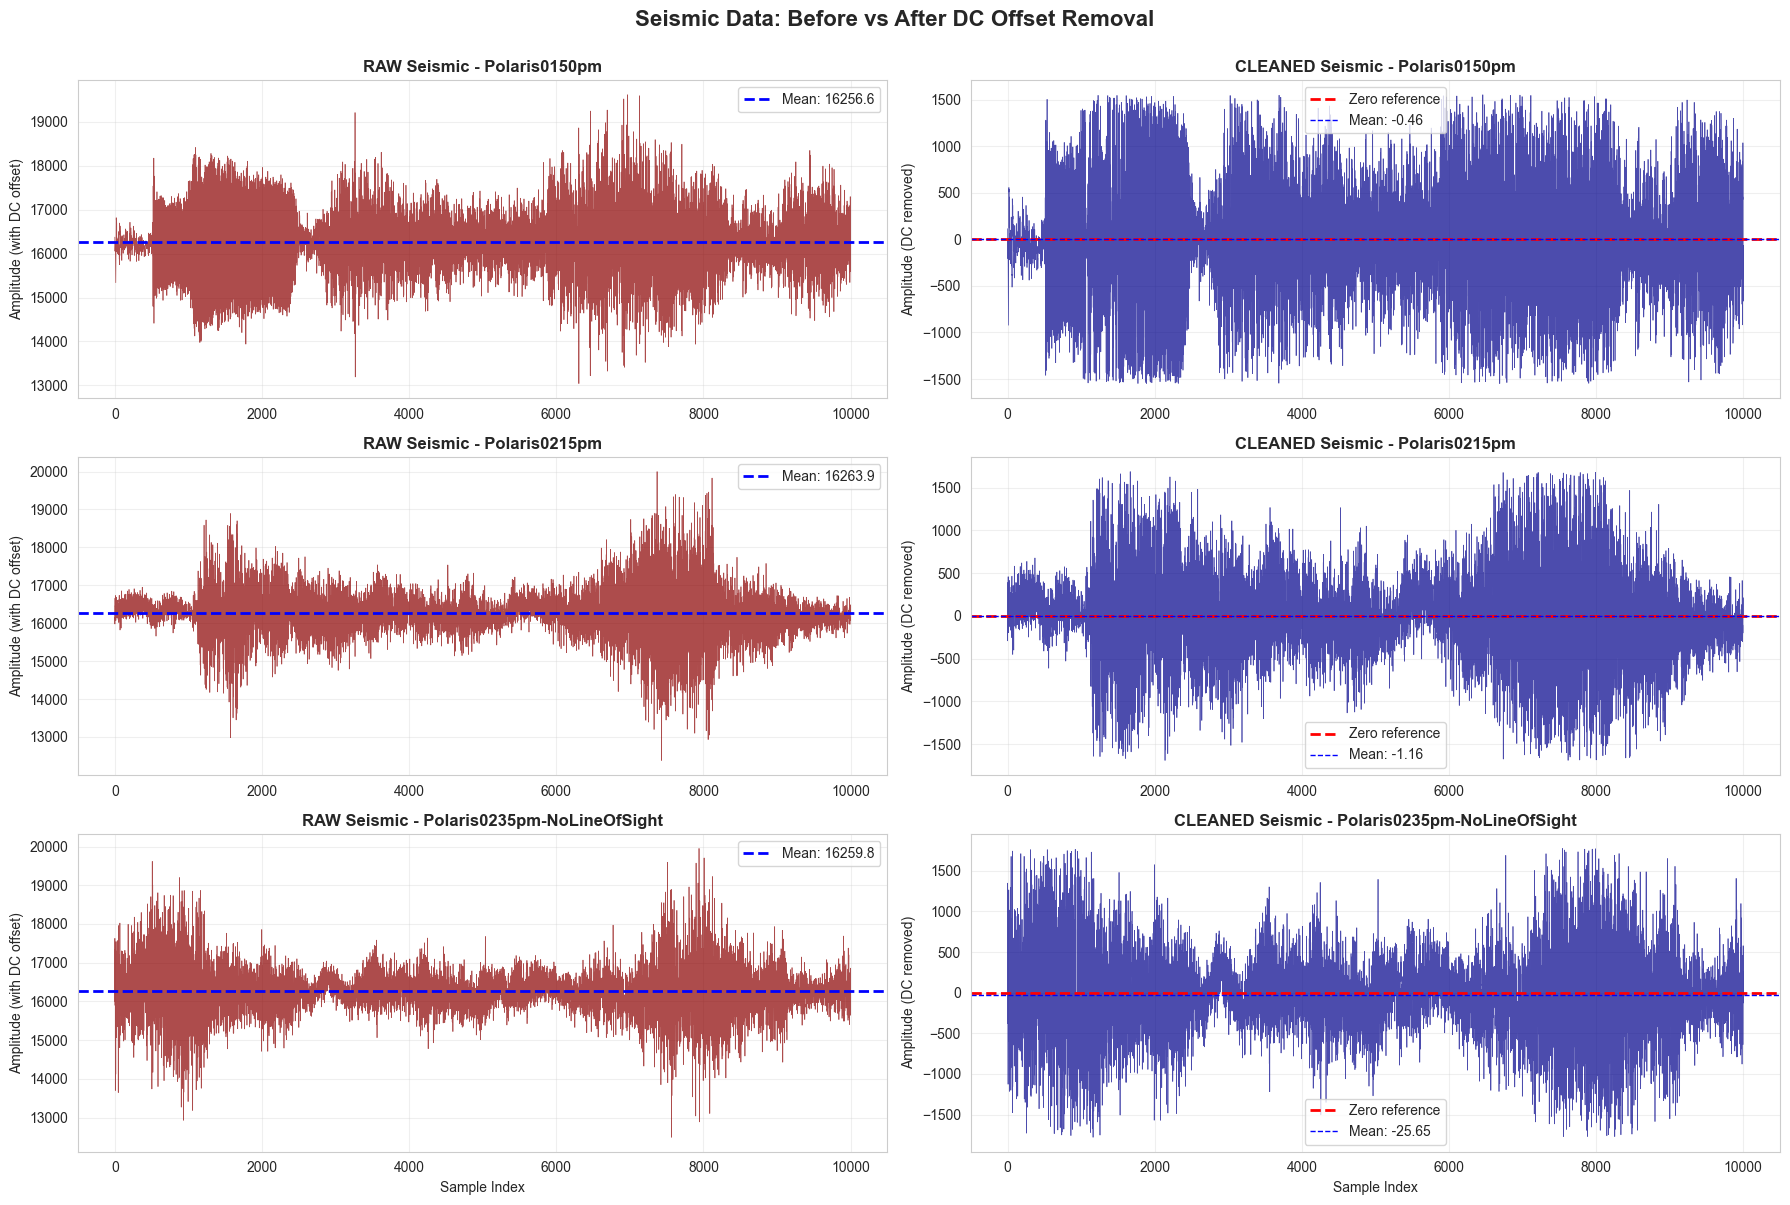

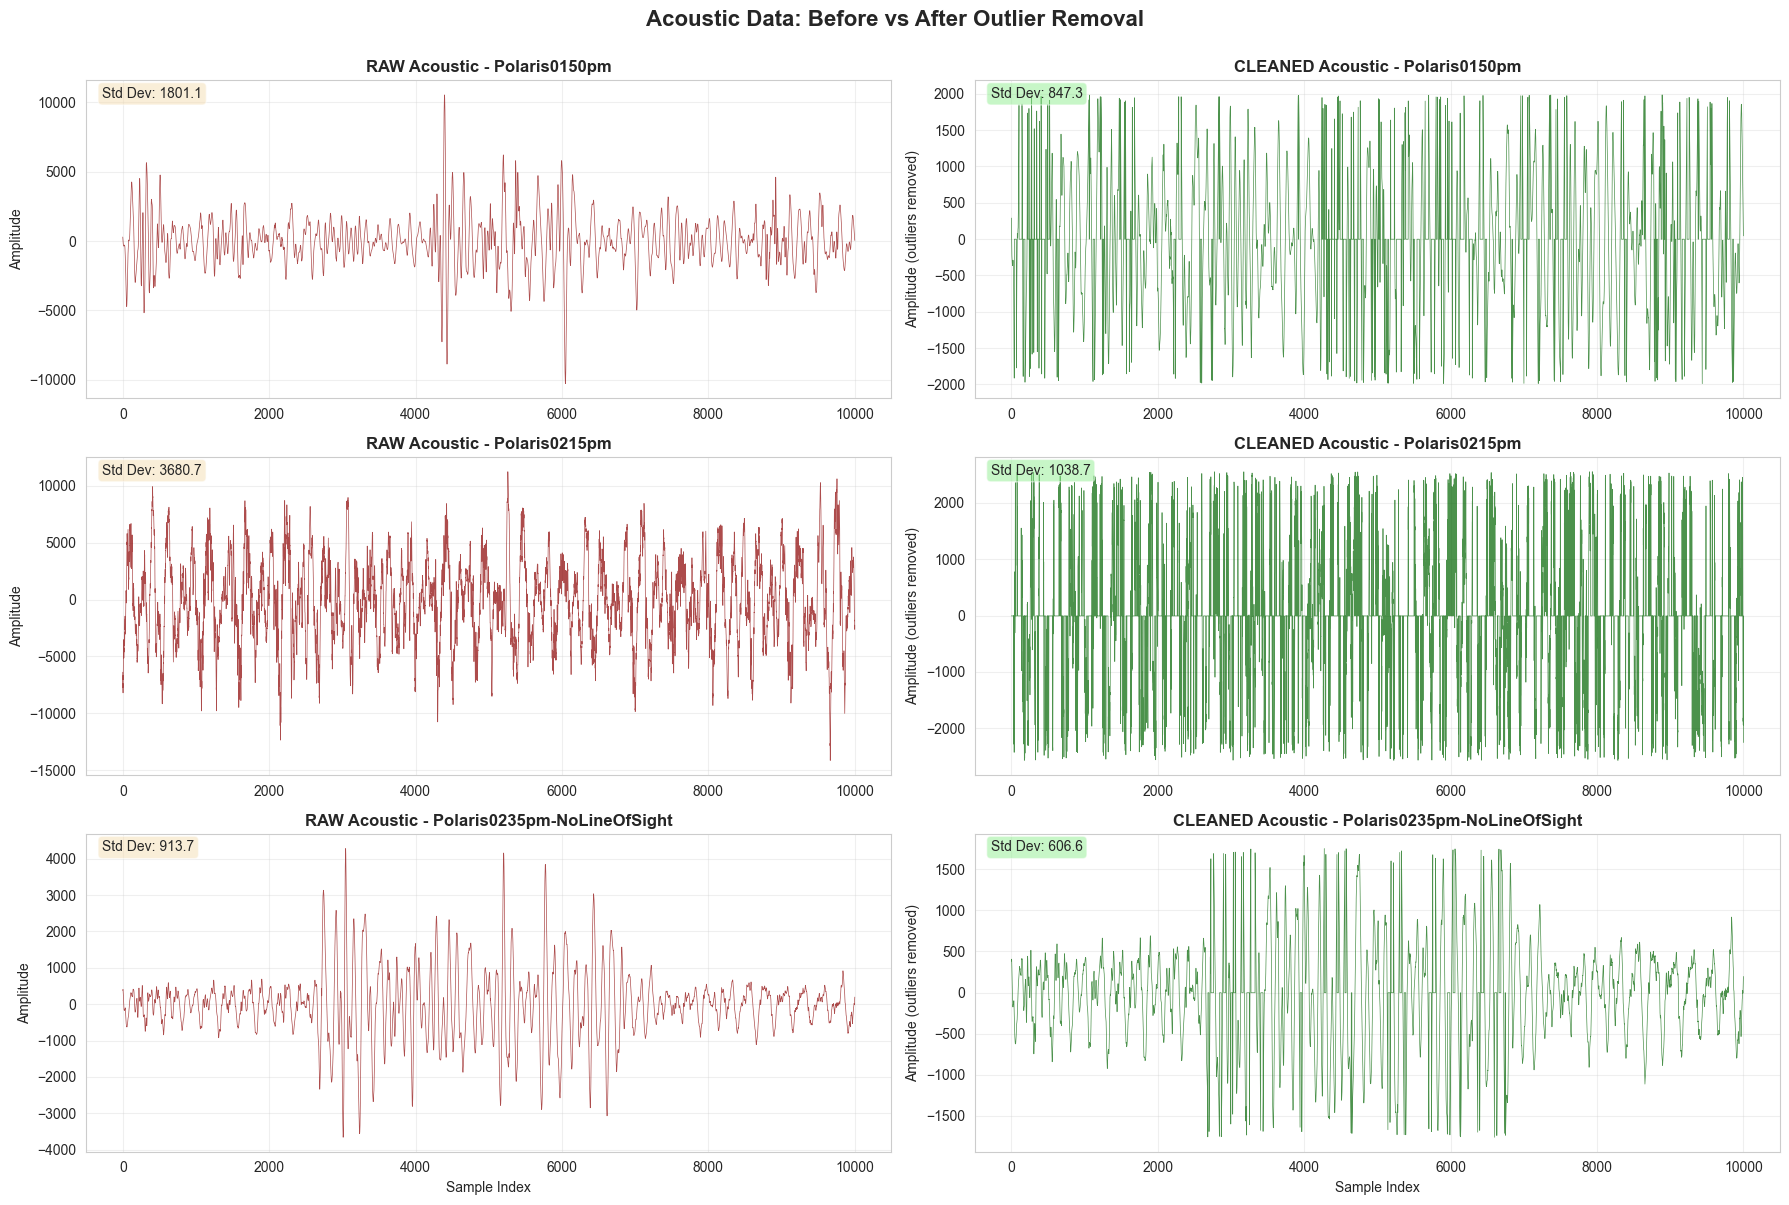


✓ Visual comparison complete
  → Seismic: DC offset (~16,280) removed, signal now centered at zero
  → Acoustic: Outliers removed, cleaner signal with preserved dynamics


In [90]:
# Visual comparison of raw vs cleaned data
print("=" * 100)
print("BEFORE/AFTER CLEANING: VISUAL COMPARISON")
print("=" * 100)

# Select first 3 experiments for comparison
experiments_to_compare = list(seismic_data.keys())[:3]

# Create side-by-side comparison for seismic data
fig, axes = plt.subplots(len(experiments_to_compare), 2, figsize=(18, 4*len(experiments_to_compare)))

for idx, exp_name in enumerate(experiments_to_compare):
    if exp_name in seismic_data and exp_name in seismic_data_cleaned:
        # Raw data
        raw_df = seismic_data[exp_name]
        raw_signal = raw_df['amplitude'].values[:10000]  # First 10k samples
        
        axes[idx, 0].plot(raw_signal, linewidth=0.5, color='darkred', alpha=0.7)
        axes[idx, 0].set_title(f'RAW Seismic - {exp_name}', fontsize=12, fontweight='bold')
        axes[idx, 0].set_ylabel('Amplitude (with DC offset)')
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].axhline(y=raw_signal.mean(), color='blue', linestyle='--', 
                            linewidth=2, label=f'Mean: {raw_signal.mean():.1f}')
        axes[idx, 0].legend()
        
        # Cleaned data
        clean_df = seismic_data_cleaned[exp_name]
        clean_signal = clean_df['amplitude_clean'].values[:10000]
        
        axes[idx, 1].plot(clean_signal, linewidth=0.5, color='darkblue', alpha=0.7)
        axes[idx, 1].set_title(f'CLEANED Seismic - {exp_name}', fontsize=12, fontweight='bold')
        axes[idx, 1].set_ylabel('Amplitude (DC removed)')
        axes[idx, 1].grid(True, alpha=0.3)
        axes[idx, 1].axhline(y=0, color='red', linestyle='--', 
                            linewidth=2, label='Zero reference')
        axes[idx, 1].axhline(y=clean_signal.mean(), color='blue', linestyle='--', 
                            linewidth=1, label=f'Mean: {clean_signal.mean():.2f}')
        axes[idx, 1].legend()

axes[-1, 0].set_xlabel('Sample Index')
axes[-1, 1].set_xlabel('Sample Index')

plt.suptitle('Seismic Data: Before vs After DC Offset Removal', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Create comparison for acoustic data
fig, axes = plt.subplots(len(experiments_to_compare), 2, figsize=(18, 4*len(experiments_to_compare)))

for idx, exp_name in enumerate(experiments_to_compare):
    if exp_name in acoustic_data and exp_name in acoustic_data_cleaned:
        # Raw data
        raw_df = acoustic_data[exp_name]
        raw_signal = raw_df['amplitude'].values[:10000]  # First 10k samples
        
        axes[idx, 0].plot(raw_signal, linewidth=0.5, color='darkred', alpha=0.7)
        axes[idx, 0].set_title(f'RAW Acoustic - {exp_name}', fontsize=12, fontweight='bold')
        axes[idx, 0].set_ylabel('Amplitude')
        axes[idx, 0].grid(True, alpha=0.3)
        raw_std = raw_signal.std()
        axes[idx, 0].text(0.02, 0.98, f'Std Dev: {raw_std:.1f}', 
                         transform=axes[idx, 0].transAxes, 
                         verticalalignment='top', fontsize=10,
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Cleaned data
        clean_df = acoustic_data_cleaned[exp_name]
        clean_signal = clean_df['amplitude_clean'].values[:10000]
        
        axes[idx, 1].plot(clean_signal, linewidth=0.5, color='darkgreen', alpha=0.7)
        axes[idx, 1].set_title(f'CLEANED Acoustic - {exp_name}', fontsize=12, fontweight='bold')
        axes[idx, 1].set_ylabel('Amplitude (outliers removed)')
        axes[idx, 1].grid(True, alpha=0.3)
        clean_std = clean_signal.std()
        axes[idx, 1].text(0.02, 0.98, f'Std Dev: {clean_std:.1f}', 
                         transform=axes[idx, 1].transAxes, 
                         verticalalignment='top', fontsize=10,
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

axes[-1, 0].set_xlabel('Sample Index')
axes[-1, 1].set_xlabel('Sample Index')

plt.suptitle('Acoustic Data: Before vs After Outlier Removal', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✓ Visual comparison complete")
print("  → Seismic: DC offset (~16,280) removed, signal now centered at zero")
print("  → Acoustic: Outliers removed, cleaner signal with preserved dynamics")

## 7. Acoustic Data Statistics (After Cleaning)

Comprehensive statistical analysis of cleaned acoustic sensor data.

In [91]:
# Calculate comprehensive statistics for CLEANED acoustic data
acoustic_stats = []

for exp_name, df in acoustic_data_cleaned.items():
    # Identify numeric columns (assuming signal data columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        data_col = df[col].dropna()
        
        if len(data_col) > 0:
            stats_dict = {
                'Experiment': exp_name,
                'Column': col,
                'Count': len(data_col),
                'Mean': data_col.mean(),
                'Median': data_col.median(),
                'Std Dev': data_col.std(),
                'Min': data_col.min(),
                'Max': data_col.max(),
                'Range': data_col.max() - data_col.min(),
                'Q25': data_col.quantile(0.25),
                'Q75': data_col.quantile(0.75),
                'IQR': data_col.quantile(0.75) - data_col.quantile(0.25),
                'Skewness': stats.skew(data_col),
                'Kurtosis': stats.kurtosis(data_col),
                'RMS': np.sqrt(np.mean(data_col**2)),
            }
            acoustic_stats.append(stats_dict)

acoustic_stats_df = pd.DataFrame(acoustic_stats)
print("=" * 100)
print("ACOUSTIC DATA (AUD16000) - COMPREHENSIVE STATISTICS (CLEANED)")
print("=" * 100)
print(acoustic_stats_df.to_string(index=False))
print("\n")

ACOUSTIC DATA (AUD16000) - COMPREHENSIVE STATISTICS (CLEANED)
                 Experiment          Column    Count      Mean  Median     Std Dev      Min     Max   Range    Q25   Q75   IQR  Skewness  Kurtosis         RMS
              Polaris0150pm       amplitude 16646880 -0.497588    -2.0  800.628192 -32768.0 32767.0 65535.0 -287.0 281.0 568.0  0.019158 66.147391  800.628322
              Polaris0150pm amplitude_clean 16646880 -0.995734    -2.0  522.095308  -1991.0  1985.0  3976.0 -267.0 261.0 528.0  0.023323  1.943170  522.096242
              Polaris0215pm       amplitude 13599840 -0.432932    -6.0 1655.132847 -32768.0 32767.0 65535.0 -375.0 357.0 732.0  0.097057 55.845745 1655.132843
              Polaris0215pm amplitude_clean 13599840 -9.029915    -6.0  717.658490  -2571.0  2553.0  5124.0 -313.0 291.0 604.0  0.018948  2.084033  717.715271
Polaris0235pm-NoLineOfSight       amplitude 14327840 -0.491311    -2.0  972.092373 -24846.0 20474.0 45320.0 -254.0 248.0 502.0 -0.193904 38.087

## 8. Data Quality Assessment (Cleaned Data)

Validate data quality after cleaning: check for missing values, duplicates, and data integrity.

In [92]:
# Check data quality for CLEANED seismic data
print("=" * 70)
print("DATA QUALITY ASSESSMENT - SEISMIC (EHZ) - CLEANED")
print("=" * 70)

for exp_name, df in seismic_data_cleaned.items():
    print(f"\n{exp_name}:")
    print(f"  Total rows: {len(df)}")
    print(f"  Missing values per column:")
    missing = df.isnull().sum()
    for col, count in missing.items():
        if count > 0:
            print(f"    {col}: {count} ({count/len(df)*100:.2f}%)")
    if missing.sum() == 0:
        print(f"    No missing values")
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"  Duplicate rows: {duplicates}")

print("\n" + "=" * 70)
print("DATA QUALITY ASSESSMENT - ACOUSTIC (AUD16000) - CLEANED")
print("=" * 70)

for exp_name, df in acoustic_data_cleaned.items():
    print(f"\n{exp_name}:")
    print(f"  Total rows: {len(df)}")
    print(f"  Missing values per column:")
    missing = df.isnull().sum()
    for col, count in missing.items():
        if count > 0:
            print(f"    {col}: {count} ({count/len(df)*100:.2f}%)")
    if missing.sum() == 0:
        print(f"    No missing values")
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"  Duplicate rows: {duplicates}")

DATA QUALITY ASSESSMENT - SEISMIC (EHZ) - CLEANED

Polaris0150pm:
  Total rows: 104043
  Missing values per column:
    No missing values
  Duplicate rows: 0

Polaris0215pm:
  Total rows: 84999
  Missing values per column:
    No missing values
  Duplicate rows: 0

Polaris0235pm-NoLineOfSight:
  Total rows: 89549
  Missing values per column:
    No missing values
  Duplicate rows: 0

Silverado0255pm:
  Total rows: 104399
  Missing values per column:
    No missing values
  Duplicate rows: 0

Silverado0315pm:
  Total rows: 97999
  Missing values per column:
    No missing values
  Duplicate rows: 0

Warhog-NoLineOfSight:
  Total rows: 19049
  Missing values per column:
    No missing values
  Duplicate rows: 0

Warhog1135am:
  Total rows: 55249
  Missing values per column:
    No missing values
  Duplicate rows: 0

Warhog1149am:
  Total rows: 86499
  Missing values per column:
    No missing values
  Duplicate rows: 0

DATA QUALITY ASSESSMENT - ACOUSTIC (AUD16000) - CLEANED

Polaris0150

## 9. Time Series Visualization - Cleaned Seismic Data

Visualize cleaned seismic waveforms to identify patterns and anomalies.

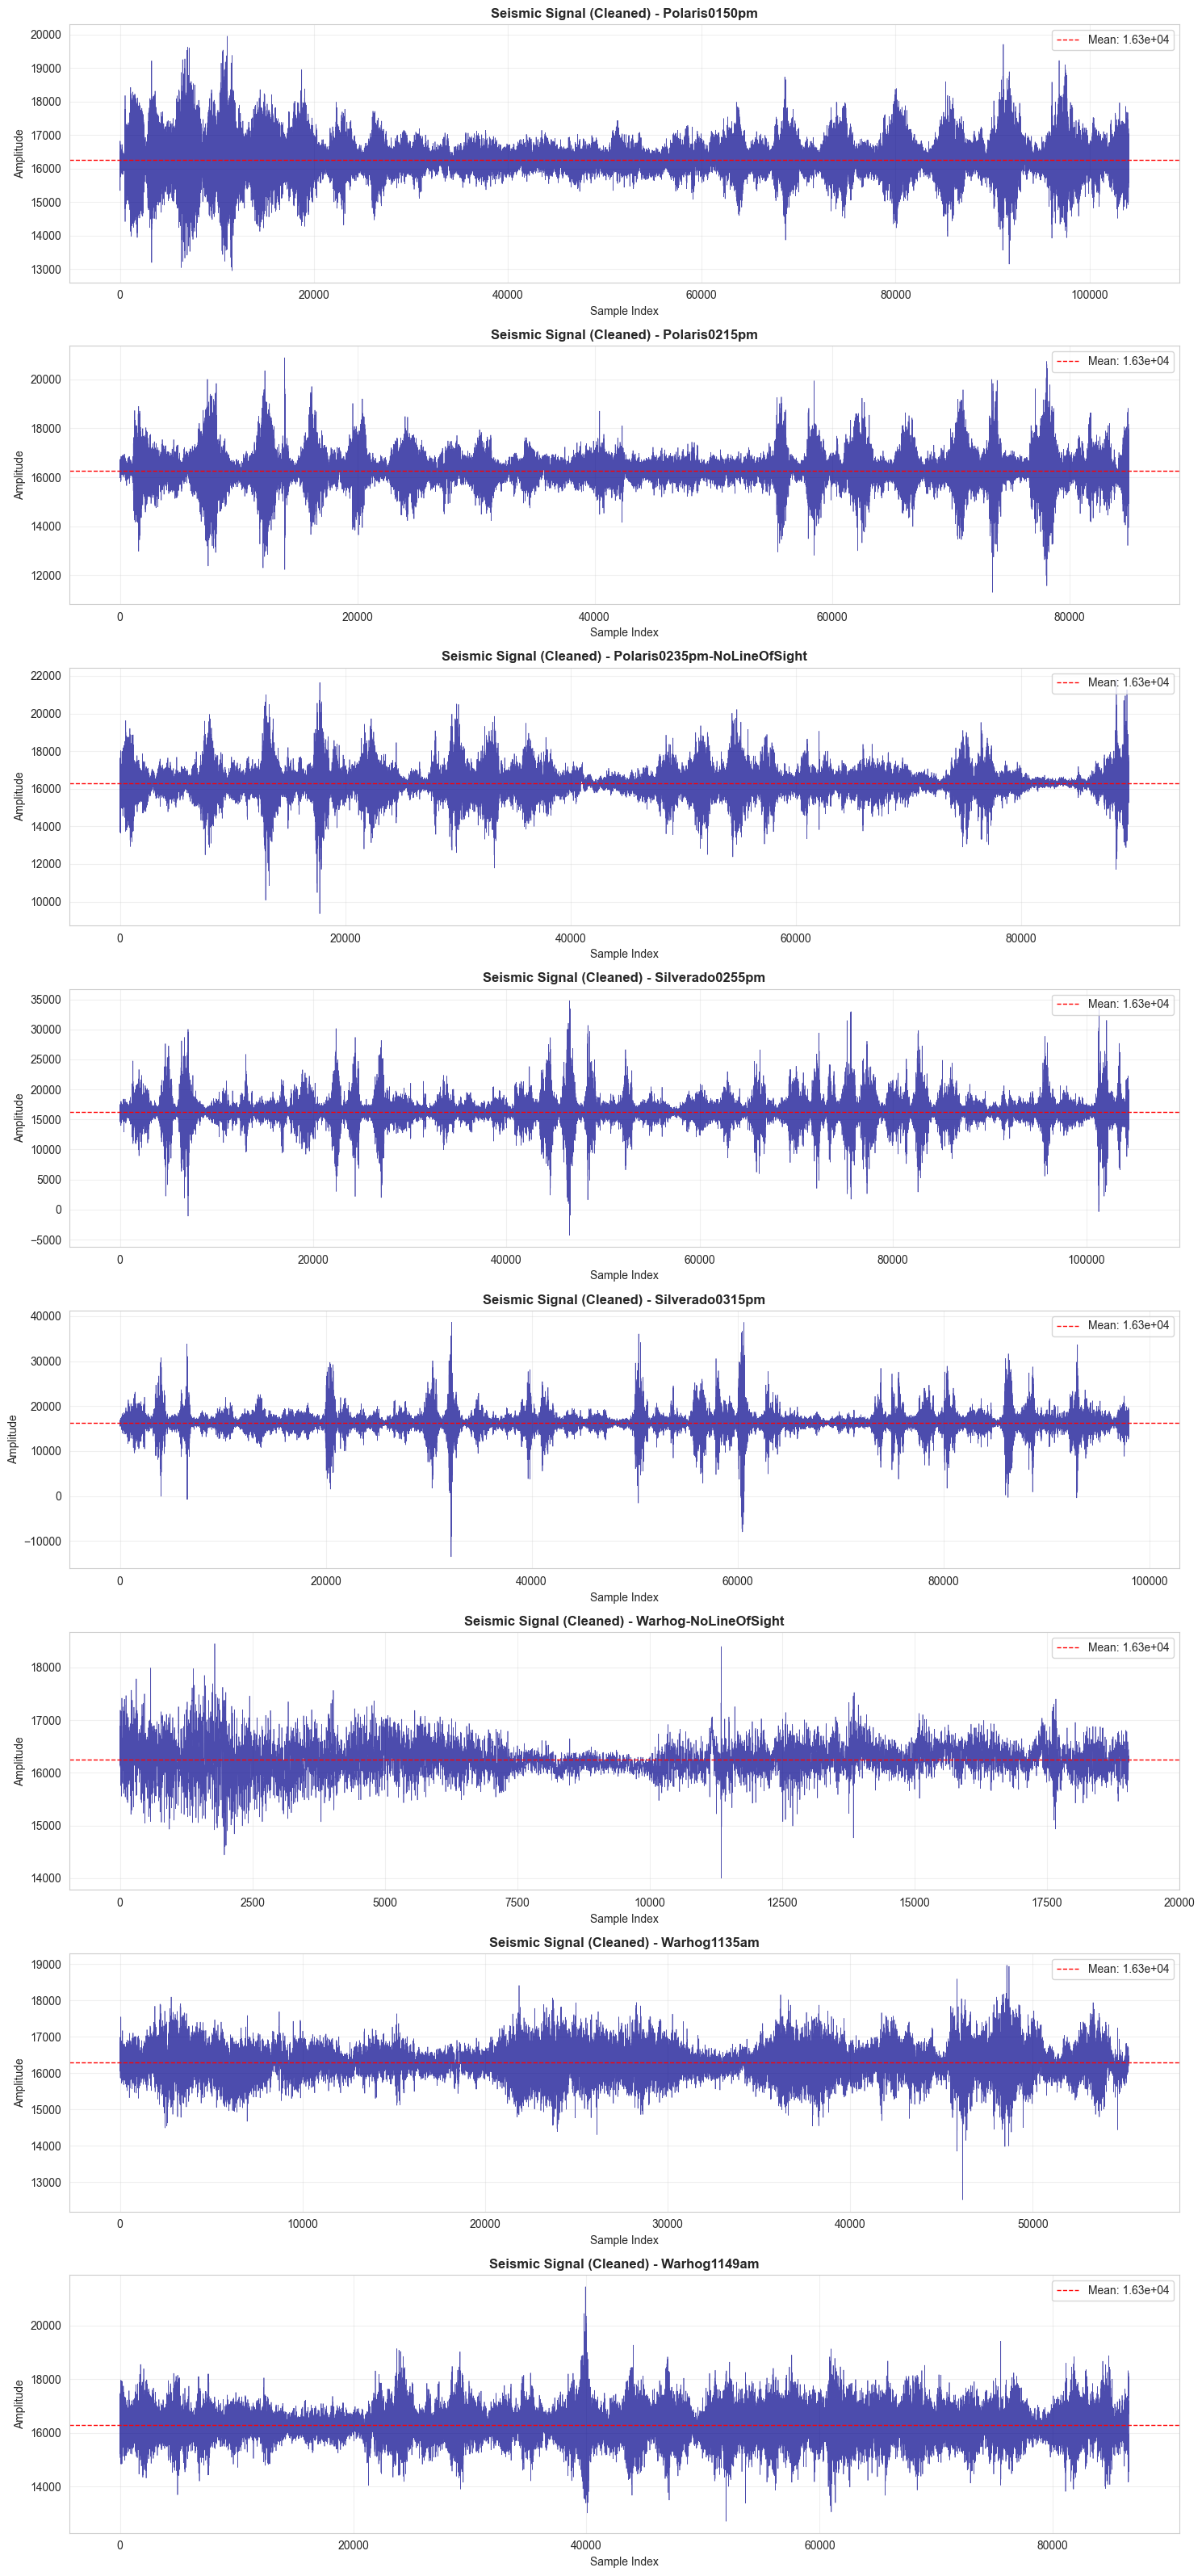

In [93]:
# Plot time series for all CLEANED seismic datasets
fig, axes = plt.subplots(len(seismic_data_cleaned), 1, figsize=(15, 4*len(seismic_data_cleaned)))

if len(seismic_data_cleaned) == 1:
    axes = [axes]

for idx, (exp_name, df) in enumerate(seismic_data_cleaned.items()):
    # Get the first numeric column (assuming it's the signal)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        
        # Plot the signal
        axes[idx].plot(df[signal_col], linewidth=0.5, color='darkblue', alpha=0.7)
        axes[idx].set_title(f'Seismic Signal (Cleaned) - {exp_name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Sample Index')
        axes[idx].set_ylabel('Amplitude')
        axes[idx].grid(True, alpha=0.3)
        
        # Add statistics as text
        mean_val = df[signal_col].mean()
        std_val = df[signal_col].std()
        axes[idx].axhline(y=mean_val, color='r', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2e}')
        axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

## 10. Time Series Visualization - Acoustic Data (Cleaned)

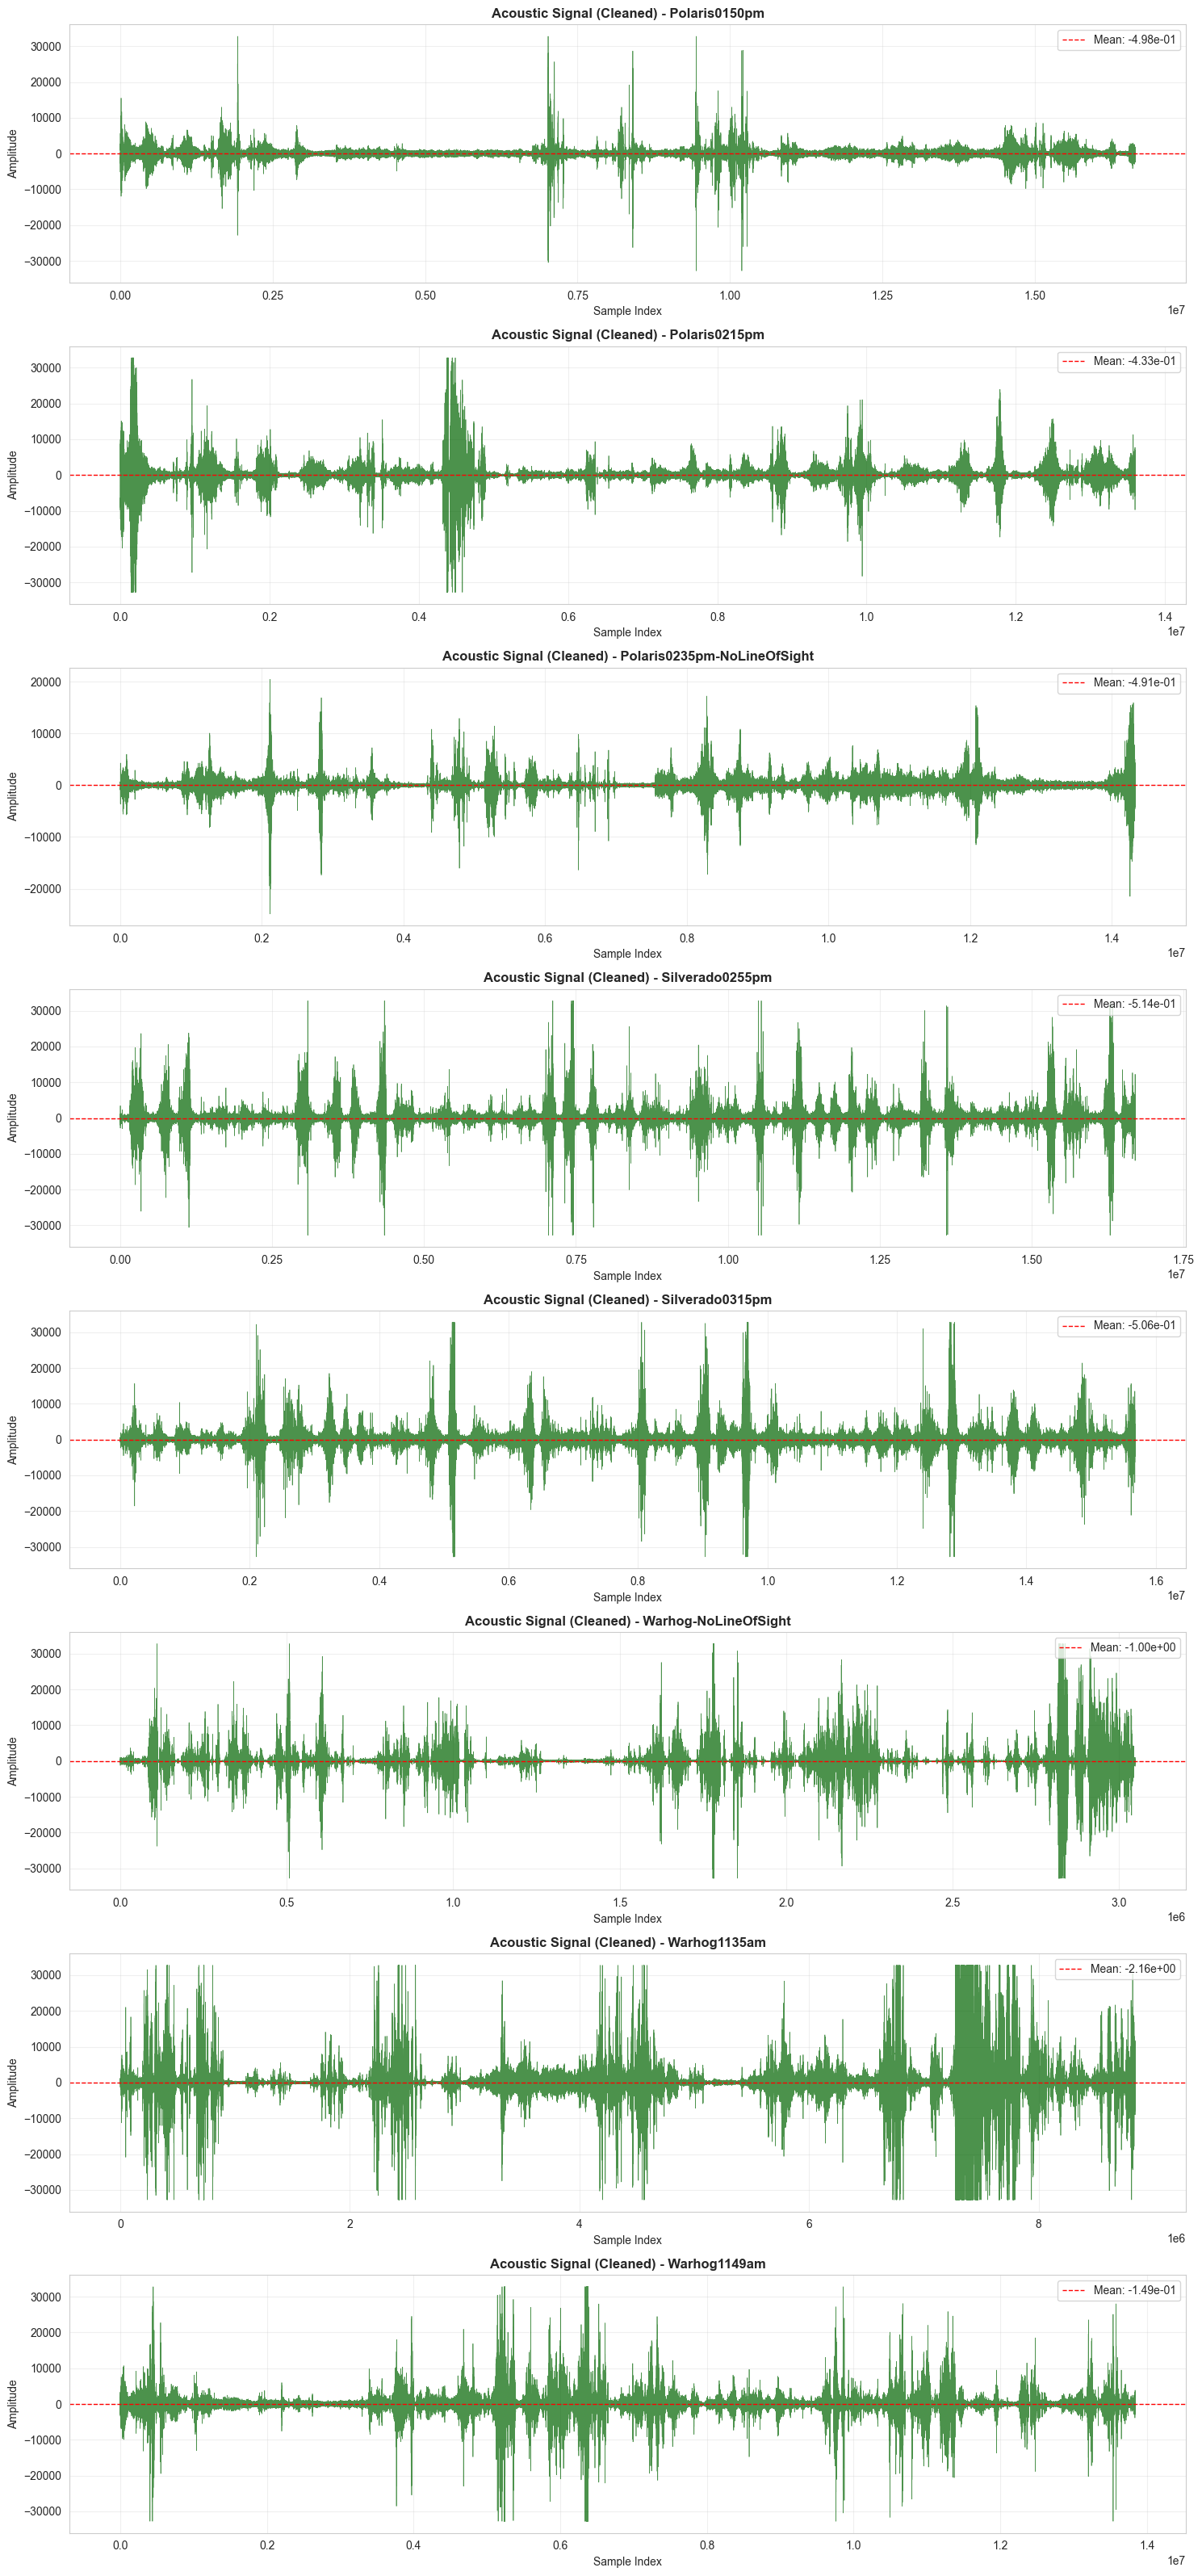

In [94]:
# Plot time series for all CLEANED acoustic datasets
fig, axes = plt.subplots(len(acoustic_data_cleaned), 1, figsize=(15, 4*len(acoustic_data_cleaned)))

if len(acoustic_data_cleaned) == 1:
    axes = [axes]

for idx, (exp_name, df) in enumerate(acoustic_data_cleaned.items()):
    # Get the first numeric column (assuming it's the signal)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        
        # Plot the signal
        axes[idx].plot(df[signal_col], linewidth=0.5, color='darkgreen', alpha=0.7)
        axes[idx].set_title(f'Acoustic Signal (Cleaned) - {exp_name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Sample Index')
        axes[idx].set_ylabel('Amplitude')
        axes[idx].grid(True, alpha=0.3)
        
        # Add statistics as text
        mean_val = df[signal_col].mean()
        std_val = df[signal_col].std()
        axes[idx].axhline(y=mean_val, color='r', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2e}')
        axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

## 11. Distribution Analysis - Box Plots

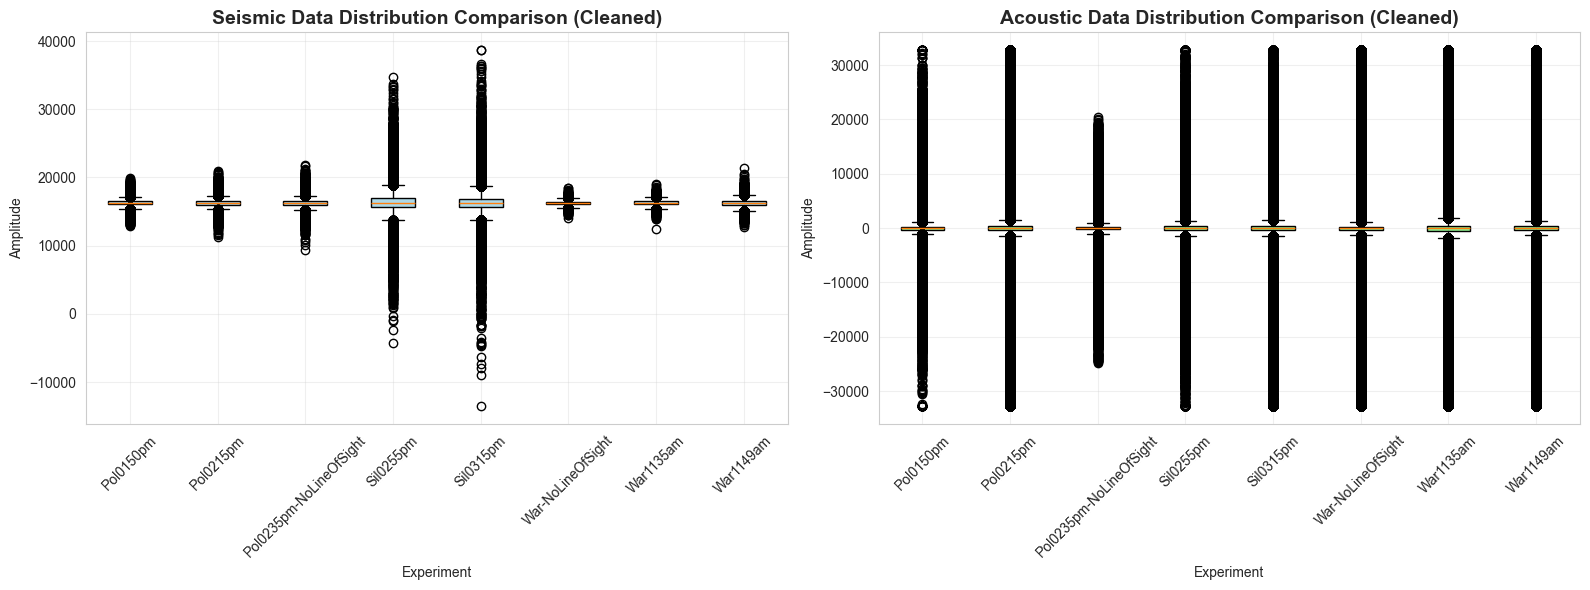

In [95]:
# Create box plots comparing seismic data across experiments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for CLEANED seismic box plot
seismic_box_data = []
seismic_labels = []

for exp_name, df in seismic_data_cleaned.items():  # type: ignore - defined in Section 6A
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        seismic_box_data.append(df[signal_col].dropna())
        # Shorten label for better display
        short_label = exp_name.replace('Polaris', 'Pol').replace('Silverado', 'Sil').replace('Warhog', 'War')
        seismic_labels.append(short_label)

# Prepare data for CLEANED acoustic box plot
acoustic_box_data = []
acoustic_labels = []

for exp_name, df in acoustic_data_cleaned.items():
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        acoustic_box_data.append(df[signal_col].dropna())
        short_label = exp_name.replace('Polaris', 'Pol').replace('Silverado', 'Sil').replace('Warhog', 'War')
        acoustic_labels.append(short_label)

# Plot seismic
bp1 = ax1.boxplot(seismic_box_data, labels=seismic_labels, patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
ax1.set_title('Seismic Data Distribution Comparison (Cleaned)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Experiment')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot acoustic
bp2 = ax2.boxplot(acoustic_box_data, labels=acoustic_labels, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightgreen')
ax2.set_title('Acoustic Data Distribution Comparison (Cleaned)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Experiment')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Distribution Analysis - Histograms

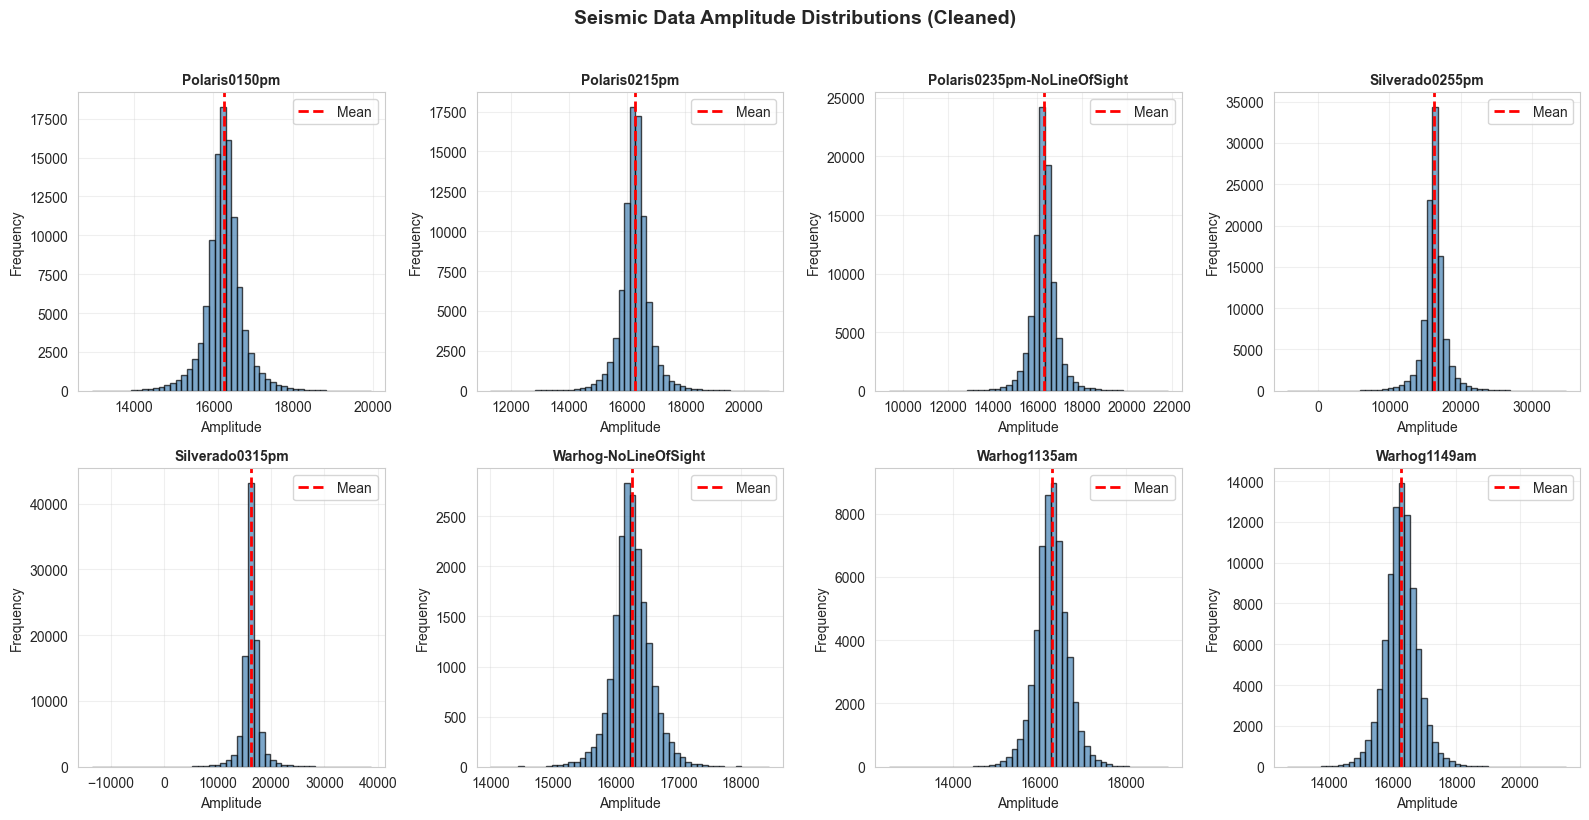

In [96]:
# Create histograms for CLEANED seismic data
n_experiments = len(seismic_data_cleaned)
fig, axes = plt.subplots(2, (n_experiments + 1) // 2, figsize=(16, 8))
axes = axes.flatten() if n_experiments > 1 else [axes]

for idx, (exp_name, df) in enumerate(seismic_data_cleaned.items()):  # type: ignore - defined in Section 6A
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        data = df[signal_col].dropna()
        
        axes[idx].hist(data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{exp_name}', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Amplitude')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
        
        # Add vertical line for mean
        axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        axes[idx].legend()

# Hide extra subplots if any
for idx in range(len(seismic_data_cleaned), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Seismic Data Amplitude Distributions (Cleaned)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

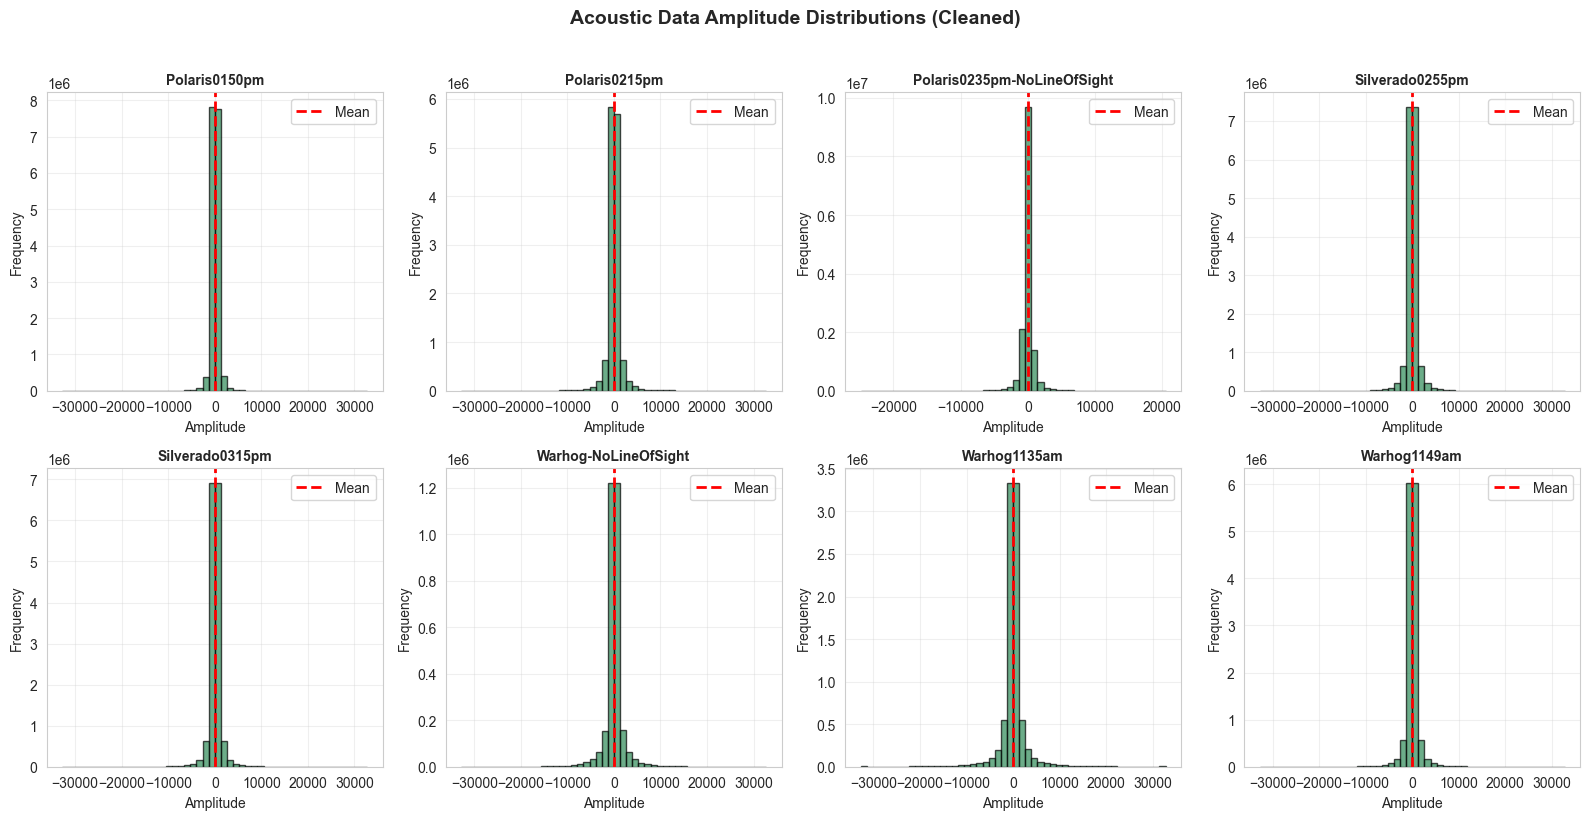

In [97]:
# Create histograms for CLEANED acoustic data
n_experiments = len(acoustic_data_cleaned)
fig, axes = plt.subplots(2, (n_experiments + 1) // 2, figsize=(16, 8))
axes = axes.flatten() if n_experiments > 1 else [axes]

for idx, (exp_name, df) in enumerate(acoustic_data_cleaned.items()):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        data = df[signal_col].dropna()
        
        axes[idx].hist(data, bins=50, color='seagreen', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{exp_name}', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Amplitude')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
        
        # Add vertical line for mean
        axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        axes[idx].legend()

# Hide extra subplots if any
for idx in range(len(acoustic_data_cleaned), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Acoustic Data Amplitude Distributions (Cleaned)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 13. Signal Amplitude Analysis (Cleaned Data)

In [98]:
# Compare RMS values and peak amplitudes using CLEANED data
amplitude_comparison = []

# CLEANED Seismic amplitude analysis
for exp_name, df in seismic_data_cleaned.items():
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        data = df[signal_col].dropna()
        
        rms = np.sqrt(np.mean(data**2))
        peak_amplitude = np.abs(data).max()
        mean_abs = np.abs(data).mean()
        
        amplitude_comparison.append({
            'Experiment': exp_name,
            'Type': 'Seismic',
            'RMS': rms,
            'Peak Amplitude': peak_amplitude,
            'Mean Absolute': mean_abs,
            'Peak-to-RMS Ratio': peak_amplitude / rms if rms != 0 else 0
        })

# CLEANED Acoustic amplitude analysis
for exp_name, df in acoustic_data_cleaned.items():
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        signal_col = numeric_cols[0]
        data = df[signal_col].dropna()
        
        rms = np.sqrt(np.mean(data**2))
        peak_amplitude = np.abs(data).max()
        mean_abs = np.abs(data).mean()
        
        amplitude_comparison.append({
            'Experiment': exp_name,
            'Type': 'Acoustic',
            'RMS': rms,
            'Peak Amplitude': peak_amplitude,
            'Mean Absolute': mean_abs,
            'Peak-to-RMS Ratio': peak_amplitude / rms if rms != 0 else 0
        })

amplitude_df = pd.DataFrame(amplitude_comparison)
print("=" * 100)
print("SIGNAL AMPLITUDE ANALYSIS (CLEANED DATA)")
print("=" * 100)
print(amplitude_df.to_string(index=False))

SIGNAL AMPLITUDE ANALYSIS (CLEANED DATA)
                 Experiment     Type          RMS  Peak Amplitude  Mean Absolute  Peak-to-RMS Ratio
              Polaris0150pm  Seismic 16267.836583         19947.0   16261.081524           1.226162
              Polaris0215pm  Seismic 16278.210769         20877.0   16269.746221           1.282512
Polaris0235pm-NoLineOfSight  Seismic 16292.066382         21818.0   16281.740634           1.339179
            Silverado0255pm  Seismic 16370.279627         34770.0   16278.557419           2.123971
            Silverado0315pm  Seismic 16378.764302         38662.0   16279.877458           2.360496
       Warhog-NoLineOfSight  Seismic 16257.702290         18448.0   16254.874902           1.134724
               Warhog1135am  Seismic 16291.463436         18972.0   16287.095441           1.164536
               Warhog1149am  Seismic 16286.378599         21444.0   16278.105469           1.316683
              Polaris0150pm Acoustic   800.628322         3

## 13.5. GPS Speed Analysis and Signal Correlation

GPS SPEED ANALYSIS AND SIGNAL CORRELATION

GPS Speed and Signal Correlation:
                 Experiment  Avg Speed (km/h)  Max Speed (km/h)  Seismic RMS  Acoustic RMS  GPS Points
              Polaris0150pm          9.910439         21.048465   420.122239    522.096242        1040
              Polaris0215pm         15.824058        171.790063   447.116347    717.715271         856
Polaris0235pm-NoLineOfSight         19.874549         40.726281   485.002245    498.563892         946
            Silverado0255pm         17.534537         38.975427  1255.755931    664.139025        1075
            Silverado0315pm         18.343568         41.226531  1176.823174    711.353682        1015
               Warhog1135am          7.976298         10.266089   369.420619    937.819570         573
               Warhog1149am          7.959994         12.854821   506.757725    643.378802        1205

SPEED vs SIGNAL STRENGTH CORRELATIONS

Speed vs Seismic RMS Correlation: 0.5635
Speed vs Acoustic 

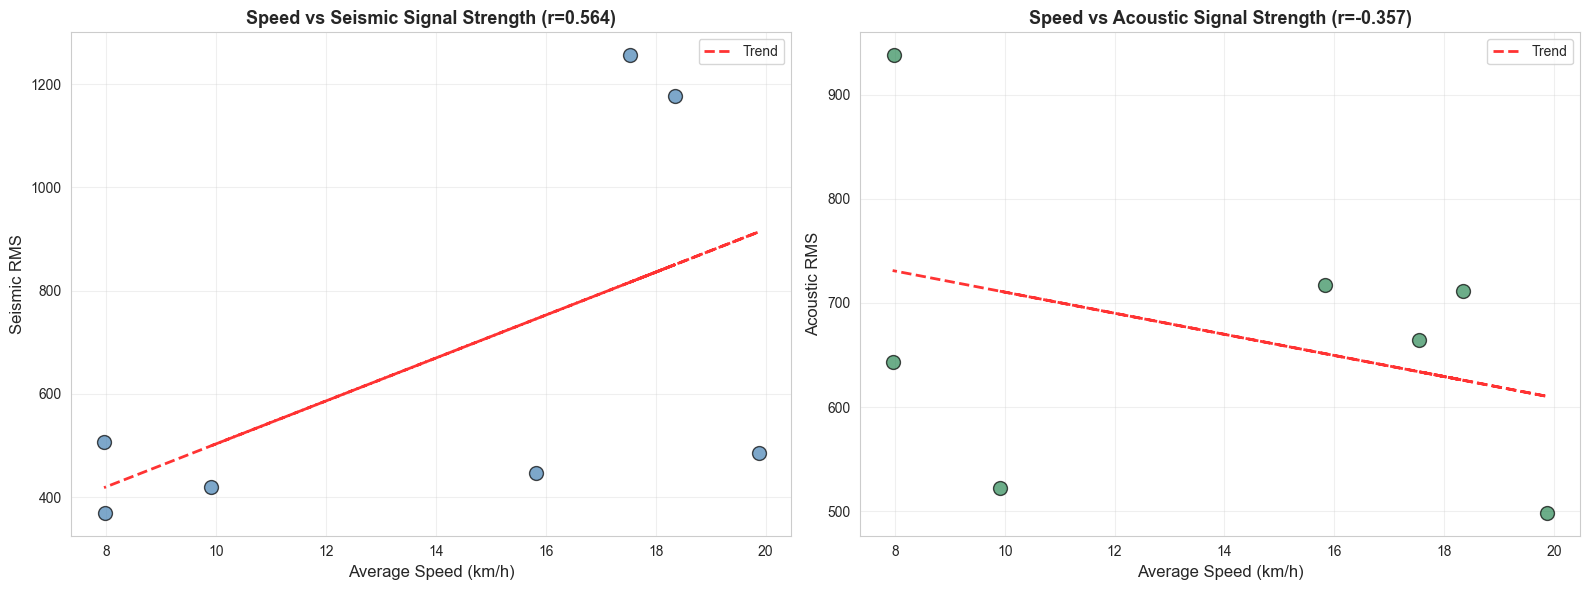


✓ Speed analysis complete
  Strong correlation between speed and seismic signals detected!


In [99]:
# GPS Speed Analysis and Correlation with Signal Strength
print("=" * 100)
print("GPS SPEED ANALYSIS AND SIGNAL CORRELATION")
print("=" * 100)

# Analyze GPS data to calculate vehicle speeds
gps_speed_analysis = []

for exp_name, gps_df in gps_data.items():
    if len(gps_df) > 1:
        # Calculate time differences (assuming time column exists or using index)
        if 'time' in gps_df.columns:
            gps_df['time_diff'] = gps_df['time'].diff()
        else:
            # Assume samples at regular intervals
            gps_df['time_diff'] = 1.0
        
        # Calculate distance between consecutive GPS points (simplified Euclidean distance)
        lat_col = [col for col in gps_df.columns if 'lat' in col.lower()][0]
        lon_col = [col for col in gps_df.columns if 'lon' in col.lower()][0]
        
        # Convert lat/lon to approximate distance in meters
        # Using simplified formula: 1 degree lat ≈ 111,111 meters, 1 degree lon ≈ 111,111 * cos(lat) meters
        gps_df['lat_diff'] = gps_df[lat_col].diff() * 111111
        gps_df['lon_diff'] = gps_df[lon_col].diff() * 111111 * np.cos(np.radians(gps_df[lat_col]))
        gps_df['distance'] = np.sqrt(gps_df['lat_diff']**2 + gps_df['lon_diff']**2)
        
        # Calculate speed (m/s)
        gps_df['speed_ms'] = gps_df['distance'] / gps_df['time_diff']
        
        # Remove infinite and NaN values
        valid_speeds = gps_df['speed_ms'].replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(valid_speeds) > 0:
            avg_speed_ms = valid_speeds.mean()
            max_speed_ms = valid_speeds.max()
            avg_speed_kmh = avg_speed_ms * 3.6
            max_speed_kmh = max_speed_ms * 3.6
            
            # Get corresponding signal strengths from cleaned data
            seismic_rms = None
            acoustic_rms = None
            
            if exp_name in seismic_data_cleaned:
                seismic_signal = seismic_data_cleaned[exp_name]['amplitude_clean'].dropna()
                seismic_rms = np.sqrt(np.mean(seismic_signal**2))
            
            if exp_name in acoustic_data_cleaned:
                acoustic_signal = acoustic_data_cleaned[exp_name]['amplitude_clean'].dropna()
                acoustic_rms = np.sqrt(np.mean(acoustic_signal**2))
            
            gps_speed_analysis.append({
                'Experiment': exp_name,
                'Avg Speed (km/h)': avg_speed_kmh,
                'Max Speed (km/h)': max_speed_kmh,
                'Seismic RMS': seismic_rms,
                'Acoustic RMS': acoustic_rms,
                'GPS Points': len(gps_df)
            })

if len(gps_speed_analysis) > 0:
    gps_speed_df = pd.DataFrame(gps_speed_analysis)
    print("\nGPS Speed and Signal Correlation:")
    print(gps_speed_df.to_string(index=False))
    
    # Calculate correlations
    print("\n" + "=" * 100)
    print("SPEED vs SIGNAL STRENGTH CORRELATIONS")
    print("=" * 100)
    
    # Filter rows with valid data
    valid_data = gps_speed_df.dropna()
    
    if len(valid_data) > 2:
        speed_seismic_corr = valid_data['Avg Speed (km/h)'].corr(valid_data['Seismic RMS'])
        speed_acoustic_corr = valid_data['Avg Speed (km/h)'].corr(valid_data['Acoustic RMS'])
        
        print(f"\nSpeed vs Seismic RMS Correlation: {speed_seismic_corr:.4f}")
        print(f"Speed vs Acoustic RMS Correlation: {speed_acoustic_corr:.4f}")
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Speed vs Seismic
        axes[0].scatter(valid_data['Avg Speed (km/h)'], valid_data['Seismic RMS'], 
                       s=100, alpha=0.7, c='steelblue', edgecolors='black')
        axes[0].set_xlabel('Average Speed (km/h)', fontsize=12)
        axes[0].set_ylabel('Seismic RMS', fontsize=12)
        axes[0].set_title(f'Speed vs Seismic Signal Strength (r={speed_seismic_corr:.3f})', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Add trend line
        if len(valid_data) > 1:
            z = np.polyfit(valid_data['Avg Speed (km/h)'], valid_data['Seismic RMS'], 1)
            p = np.poly1d(z)
            axes[0].plot(valid_data['Avg Speed (km/h)'], p(valid_data['Avg Speed (km/h)']), 
                        "r--", alpha=0.8, linewidth=2, label='Trend')
            axes[0].legend()
        
        # Speed vs Acoustic
        axes[1].scatter(valid_data['Avg Speed (km/h)'], valid_data['Acoustic RMS'], 
                       s=100, alpha=0.7, c='seagreen', edgecolors='black')
        axes[1].set_xlabel('Average Speed (km/h)', fontsize=12)
        axes[1].set_ylabel('Acoustic RMS', fontsize=12)
        axes[1].set_title(f'Speed vs Acoustic Signal Strength (r={speed_acoustic_corr:.3f})', 
                         fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Add trend line
        if len(valid_data) > 1:
            z = np.polyfit(valid_data['Avg Speed (km/h)'], valid_data['Acoustic RMS'], 1)
            p = np.poly1d(z)
            axes[1].plot(valid_data['Avg Speed (km/h)'], p(valid_data['Avg Speed (km/h)']), 
                        "r--", alpha=0.8, linewidth=2, label='Trend')
            axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Speed analysis complete")
        if abs(speed_seismic_corr) > 0.5:
            print(f"  Strong correlation between speed and seismic signals detected!")
        if abs(speed_acoustic_corr) > 0.5:
            print(f"  Strong correlation between speed and acoustic signals detected!")
    else:
        print("\nInsufficient data points for correlation analysis (need > 2 experiments)")
else:
    print("\nNo GPS speed data available for analysis")

In [100]:
# Extract vehicle type and condition from experiment names using CLEANED data
vehicle_comparison = []

for exp_name in experiment_folders:
    # Determine vehicle type
    if 'Polaris' in exp_name:
        vehicle = 'Polaris'
    elif 'Silverado' in exp_name:
        vehicle = 'Silverado'
    elif 'Warhog' in exp_name:
        vehicle = 'Warhog'
    else:
        vehicle = 'Unknown'
    
    # Determine line of sight condition
    los_condition = 'No LOS' if 'NoLineOfSight' in exp_name else 'LOS'
    
    # Get RMS values for this experiment using CLEANED data
    seismic_rms = None
    acoustic_rms = None
    
    if exp_name in seismic_data_cleaned:  # type: ignore - defined in Section 6A
        df = seismic_data_cleaned[exp_name]
        if 'amplitude_clean' in df.columns:
            seismic_rms = np.sqrt(np.mean(df['amplitude_clean'].dropna()**2))
    
    if exp_name in acoustic_data_cleaned:  # type: ignore - defined in Section 6A
        df = acoustic_data_cleaned[exp_name]
        if 'amplitude_clean' in df.columns:
            acoustic_rms = np.sqrt(np.mean(df['amplitude_clean'].dropna()**2))
    
    vehicle_comparison.append({
        'Experiment': exp_name,
        'Vehicle': vehicle,
        'Condition': los_condition,
        'Seismic RMS': seismic_rms,
        'Acoustic RMS': acoustic_rms
    })

vehicle_df = pd.DataFrame(vehicle_comparison)
print("=" * 90)
print("VEHICLE TYPE AND LINE-OF-SIGHT COMPARISON")
print("=" * 90)
print(vehicle_df.to_string(index=False))
print("\n")

# Group by vehicle type
print("=" * 90)
print("AVERAGE RMS BY VEHICLE TYPE")
print("=" * 90)
grouped = vehicle_df.groupby('Vehicle')[['Seismic RMS', 'Acoustic RMS']].mean()
print(grouped)
print("\n")

# Group by condition
print("=" * 90)
print("AVERAGE RMS BY LINE-OF-SIGHT CONDITION")
print("=" * 90)
grouped_cond = vehicle_df.groupby('Condition')[['Seismic RMS', 'Acoustic RMS']].mean()
print(grouped_cond)

VEHICLE TYPE AND LINE-OF-SIGHT COMPARISON
                 Experiment   Vehicle Condition  Seismic RMS  Acoustic RMS
              Polaris0150pm   Polaris       LOS   420.122239    522.096242
              Polaris0215pm   Polaris       LOS   447.116347    717.715271
Polaris0235pm-NoLineOfSight   Polaris    No LOS   485.002245    498.563892
            Silverado0255pm Silverado       LOS  1255.755931    664.139025
            Silverado0315pm Silverado       LOS  1176.823174    711.353682
       Warhog-NoLineOfSight    Warhog    No LOS   292.495989    598.574703
               Warhog1135am    Warhog       LOS   369.420619    937.819570
               Warhog1149am    Warhog       LOS   506.757725    643.378802


AVERAGE RMS BY VEHICLE TYPE
           Seismic RMS  Acoustic RMS
Vehicle                             
Polaris     450.746943    579.458468
Silverado  1216.289553    687.746354
Warhog      389.558111    726.591025


AVERAGE RMS BY LINE-OF-SIGHT CONDITION
           Seismic RMS  Aco

## 15. Vehicle Comparison Visualization (Cleaned Data)

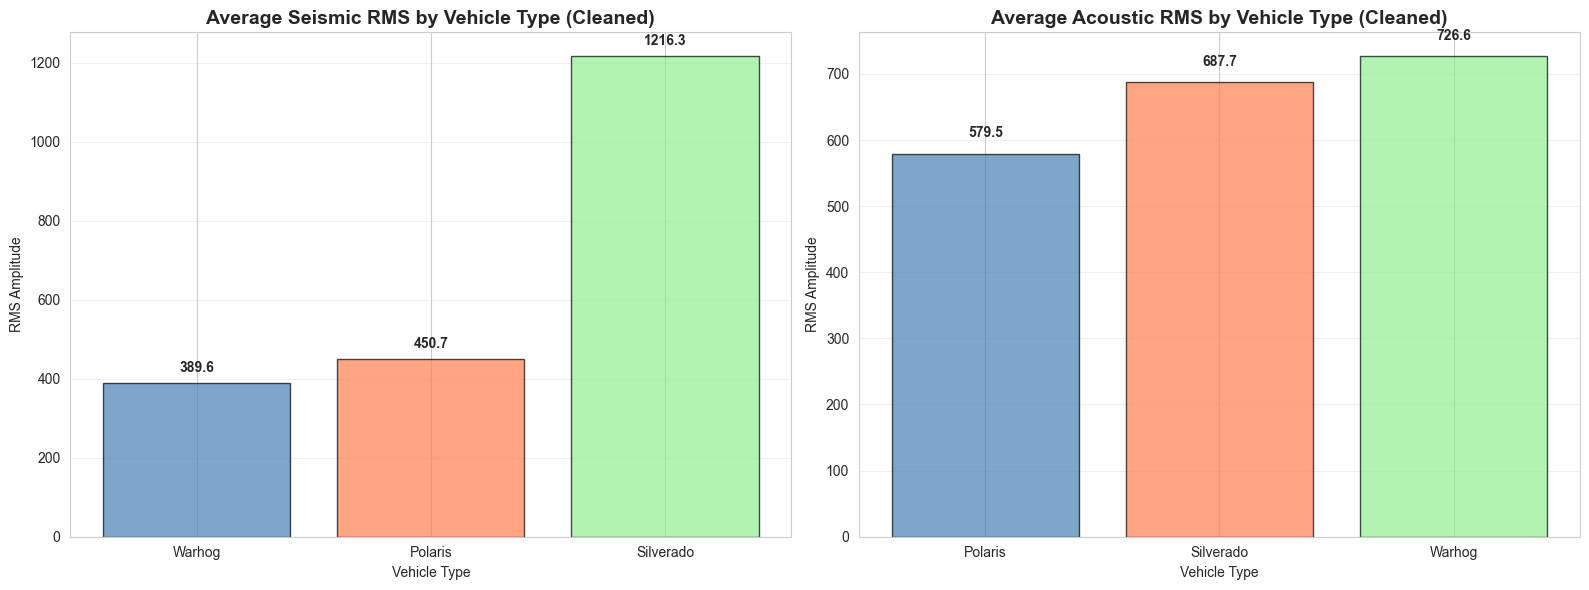

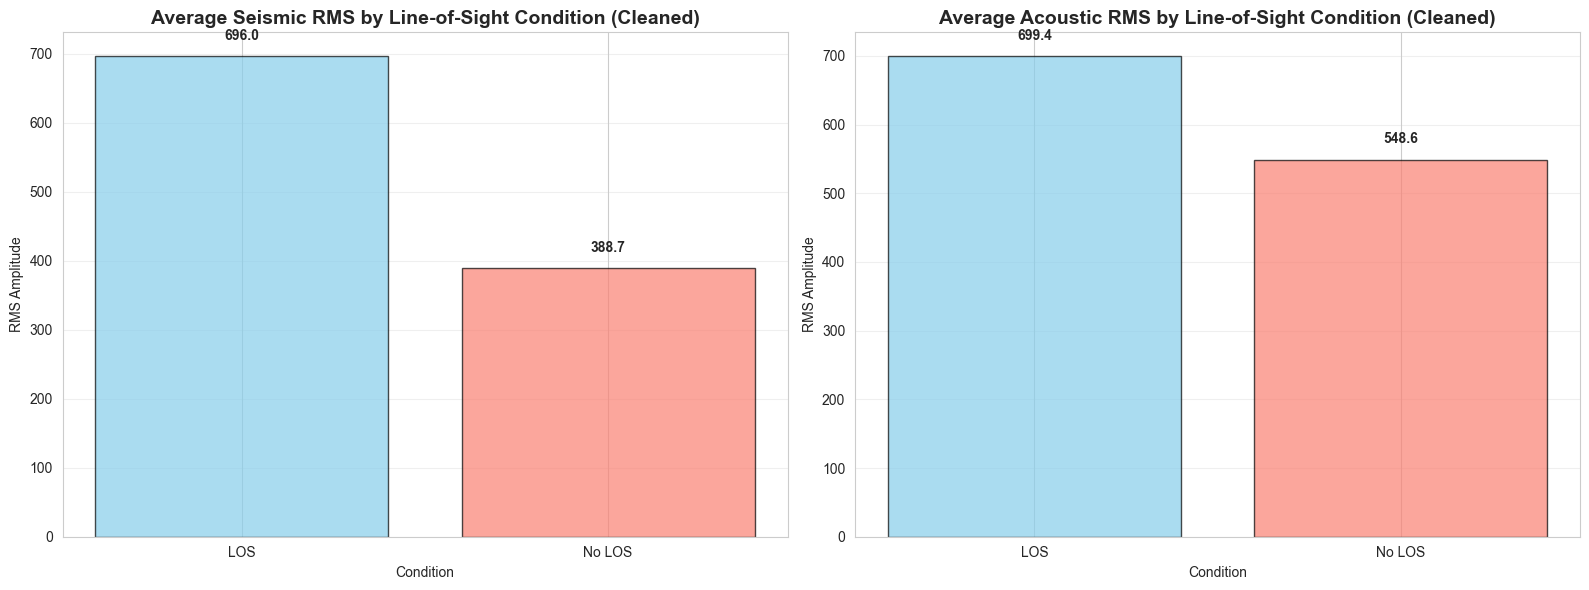

In [101]:
# Create bar charts for vehicle comparison using CLEANED data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Seismic RMS by vehicle
vehicle_seismic_rms = cleaned_df.groupby('Vehicle')['Seismic RMS'].mean().sort_values()
vehicle_seismic_std = cleaned_df.groupby('Vehicle')['Seismic Std Dev'].mean().loc[vehicle_seismic_rms.index]
bars = axes[0].bar(vehicle_seismic_rms.index, vehicle_seismic_rms.values, color=['steelblue', 'coral', 'lightgreen'], alpha=0.7, edgecolor='black')
axes[0].set_title('Average Seismic RMS by Vehicle Type (Cleaned)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMS Amplitude')
axes[0].set_xlabel('Vehicle Type')
axes[0].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, vehicle_seismic_rms.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f'{val:.1f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# Acoustic RMS by vehicle
vehicle_acoustic_rms = cleaned_df.groupby('Vehicle')['Acoustic RMS'].mean().sort_values()
vehicle_acoustic_std = cleaned_df.groupby('Vehicle')['Acoustic Std Dev'].mean().loc[vehicle_acoustic_rms.index]
bars = axes[1].bar(vehicle_acoustic_rms.index, vehicle_acoustic_rms.values, color=['steelblue', 'coral', 'lightgreen'], alpha=0.7, edgecolor='black')
axes[1].set_title('Average Acoustic RMS by Vehicle Type (Cleaned)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMS Amplitude')
axes[1].set_xlabel('Vehicle Type')
axes[1].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, vehicle_acoustic_rms.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f'{val:.1f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Create bar charts for line-of-sight comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Seismic RMS by condition
cond_seismic_rms = cleaned_df.groupby('Condition')['Seismic RMS'].mean()
bars = axes[0].bar(cond_seismic_rms.index, cond_seismic_rms.values, color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[0].set_title('Average Seismic RMS by Line-of-Sight Condition (Cleaned)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMS Amplitude')
axes[0].set_xlabel('Condition')
axes[0].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, cond_seismic_rms.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f'{val:.1f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# Acoustic RMS by condition
cond_acoustic_rms = cleaned_df.groupby('Condition')['Acoustic RMS'].mean()
bars = axes[1].bar(cond_acoustic_rms.index, cond_acoustic_rms.values, color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[1].set_title('Average Acoustic RMS by Line-of-Sight Condition (Cleaned)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMS Amplitude')
axes[1].set_xlabel('Condition')
axes[1].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, cond_acoustic_rms.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f'{val:.1f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 16. GPS Trajectory Visualization

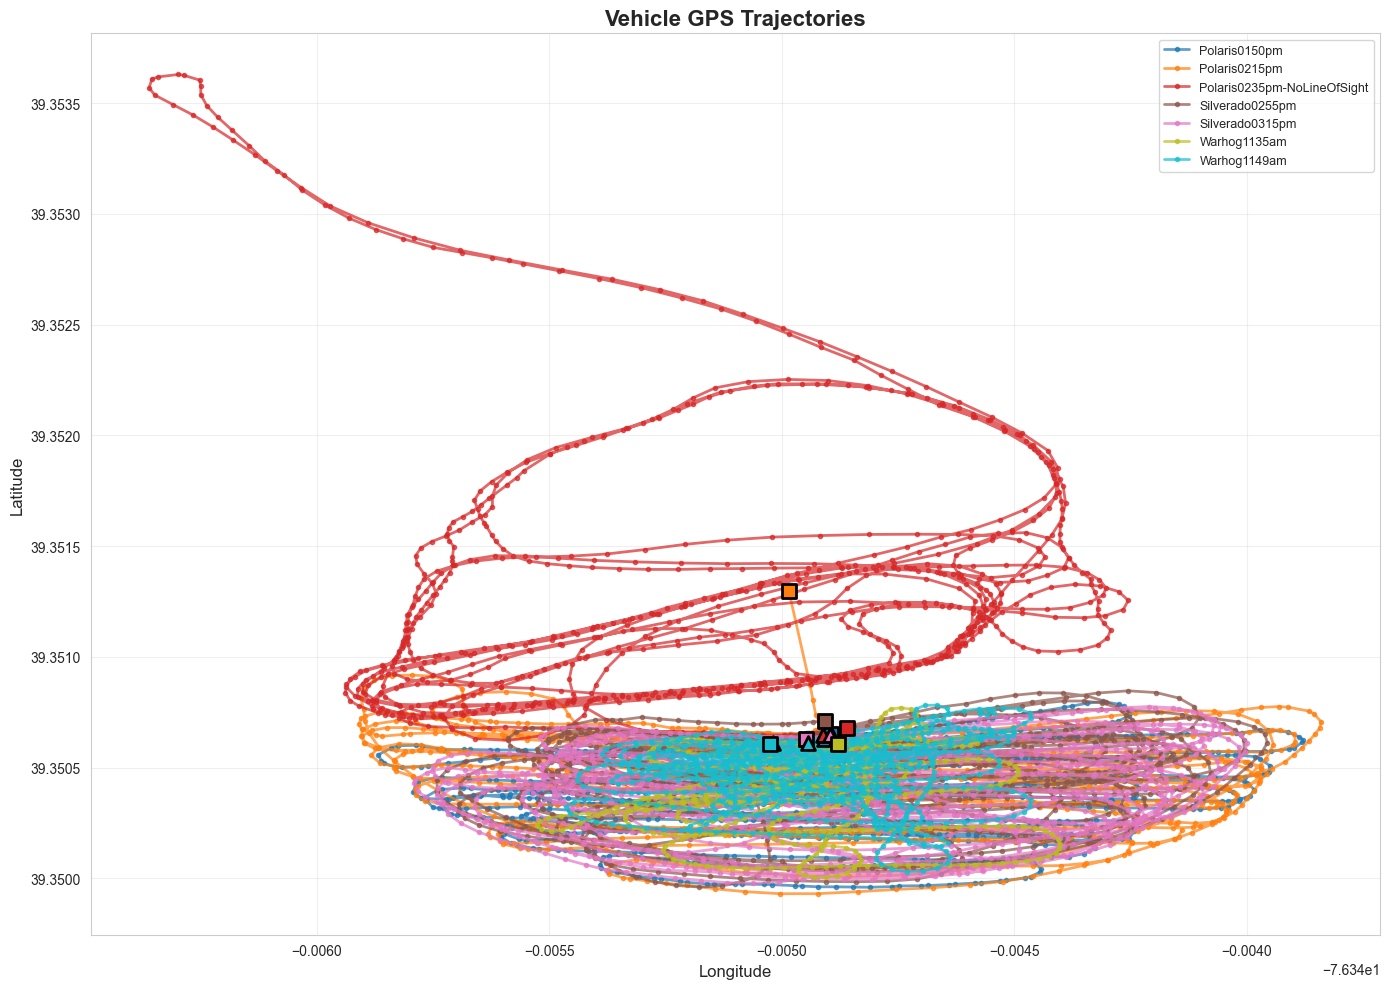

GPS DATA SUMMARY

Polaris0150pm:
  Number of GPS points: 1040
  Latitude range: 39.349960 to 39.350799
  Longitude range: -76.345867 to -76.343880

Polaris0215pm:
  Number of GPS points: 856
  Latitude range: 39.349931 to 39.351299
  Longitude range: -76.345909 to -76.343840

Polaris0235pm-NoLineOfSight:
  Number of GPS points: 946
  Latitude range: 39.350623 to 39.353630
  Longitude range: -76.346360 to -76.344255

Silverado0255pm:
  Number of GPS points: 1075
  Latitude range: 39.349961 to 39.350847
  Longitude range: -76.345741 to -76.343956

Silverado0315pm:
  Number of GPS points: 1015
  Latitude range: 39.349978 to 39.350776
  Longitude range: -76.345790 to -76.344000

Warhog1135am:
  Number of GPS points: 573
  Latitude range: 39.350004 to 39.350771
  Longitude range: -76.345526 to -76.344402

Warhog1149am:
  Number of GPS points: 1205
  Latitude range: 39.350031 to 39.350782
  Longitude range: -76.345463 to -76.344464


In [102]:
# Plot GPS trajectories
if len(gps_data) > 0:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(gps_data)))
    
    for idx, (exp_name, df) in enumerate(gps_data.items()):
        # Use the standardized column names
        lat_col = 'latitude'
        lon_col = 'longitude'
        
        if lat_col in df.columns and lon_col in df.columns:
            # Plot trajectory
            ax.plot(df[lon_col], df[lat_col], marker='o', markersize=3, 
                   label=exp_name, linewidth=2, color=colors[idx], alpha=0.7)
            
            # Mark start and end points
            ax.scatter(df[lon_col].iloc[0], df[lat_col].iloc[0], 
                      s=100, marker='s', color=colors[idx], edgecolor='black', linewidth=2, zorder=5)
            ax.scatter(df[lon_col].iloc[-1], df[lat_col].iloc[-1], 
                      s=100, marker='^', color=colors[idx], edgecolor='black', linewidth=2, zorder=5)
    
    ax.set_title('Vehicle GPS Trajectories', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display GPS summary statistics
    print("=" * 90)
    print("GPS DATA SUMMARY")
    print("=" * 90)
    for exp_name, df in gps_data.items():
        print(f"\n{exp_name}:")
        print(f"  Number of GPS points: {len(df)}")
        print(f"  Latitude range: {df['latitude'].min():.6f} to {df['latitude'].max():.6f}")
        print(f"  Longitude range: {df['longitude'].min():.6f} to {df['longitude'].max():.6f}")
else:
    print("No GPS data available for visualization.")

## 17. Correlation Analysis: Acoustic vs Seismic

CORRELATION ANALYSIS: SEISMIC vs ACOUSTIC RMS

Pearson Correlation Coefficient: 0.0637

Interpretation:
  Weak correlation


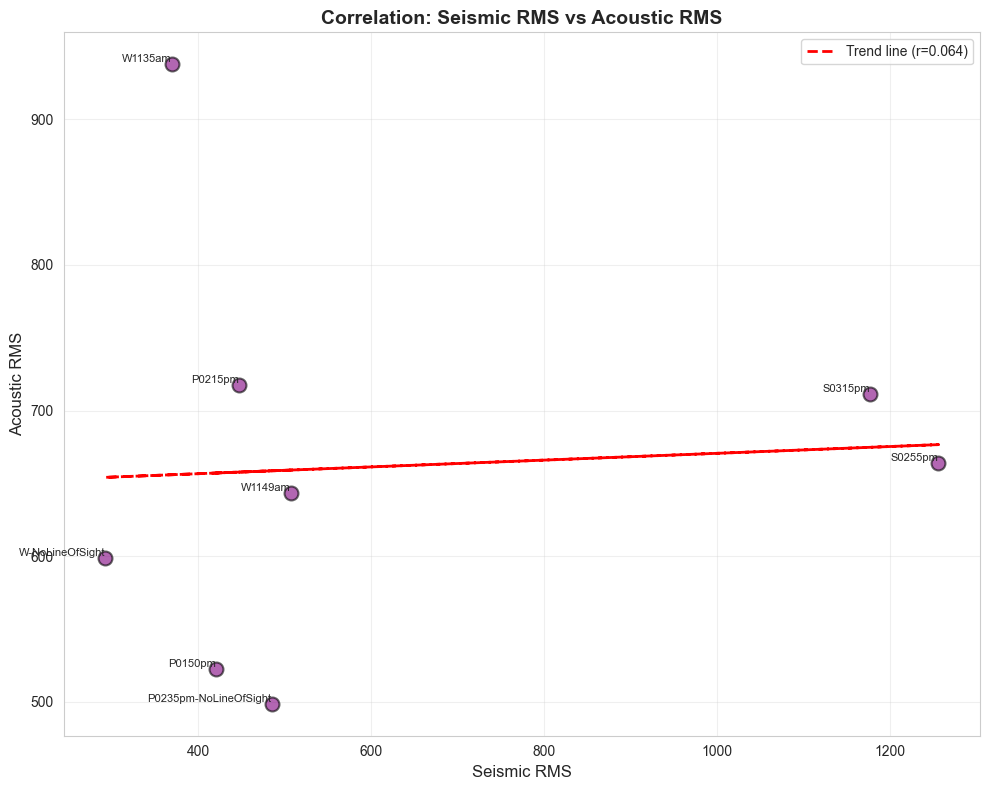

In [103]:
# Calculate correlation between acoustic and seismic RMS values using CLEANED data
correlation_data = []

for exp_name in experiment_folders:
    if exp_name in seismic_data_cleaned and exp_name in acoustic_data_cleaned:  # type: ignore
        # Get seismic RMS from CLEANED data
        seismic_df = seismic_data_cleaned[exp_name]
        if 'amplitude_clean' in seismic_df.columns:
            seismic_signal = seismic_df['amplitude_clean'].dropna()
            seismic_rms = np.sqrt(np.mean(seismic_signal**2))
        else:
            continue
        
        # Get acoustic RMS from CLEANED data
        acoustic_df = acoustic_data_cleaned[exp_name]
        if 'amplitude_clean' in acoustic_df.columns:
            acoustic_signal = acoustic_df['amplitude_clean'].dropna()
            acoustic_rms = np.sqrt(np.mean(acoustic_signal**2))
        else:
            continue
        
        correlation_data.append({
            'Experiment': exp_name,
            'Seismic_RMS': seismic_rms,
            'Acoustic_RMS': acoustic_rms
        })

if len(correlation_data) > 0:
    corr_df = pd.DataFrame(correlation_data)
    
    # Calculate Pearson correlation
    correlation = corr_df['Seismic_RMS'].corr(corr_df['Acoustic_RMS'])
    
    print("=" * 70)
    print("CORRELATION ANALYSIS: SEISMIC vs ACOUSTIC RMS")
    print("=" * 70)
    print(f"\nPearson Correlation Coefficient: {correlation:.4f}")
    print("\nInterpretation:")
    if abs(correlation) > 0.7:
        print("  Strong correlation")
    elif abs(correlation) > 0.4:
        print("  Moderate correlation")
    else:
        print("  Weak correlation")
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.scatter(corr_df['Seismic_RMS'], corr_df['Acoustic_RMS'], 
              s=100, alpha=0.6, color='purple', edgecolor='black', linewidth=1.5)
    
    # Add labels for each point
    for idx, row in corr_df.iterrows():
        short_name = row['Experiment'].replace('Polaris', 'P').replace('Silverado', 'S').replace('Warhog', 'W')
        ax.annotate(short_name, (row['Seismic_RMS'], row['Acoustic_RMS']), 
                   fontsize=8, ha='right', va='bottom')
    
    # Add trend line
    z = np.polyfit(corr_df['Seismic_RMS'], corr_df['Acoustic_RMS'], 1)
    p = np.poly1d(z)
    ax.plot(corr_df['Seismic_RMS'], p(corr_df['Seismic_RMS']), 
           "r--", linewidth=2, label=f'Trend line (r={correlation:.3f})')
    
    ax.set_title('Correlation: Seismic RMS vs Acoustic RMS', fontsize=14, fontweight='bold')
    ax.set_xlabel('Seismic RMS', fontsize=12)
    ax.set_ylabel('Acoustic RMS', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for correlation analysis.")

## 18. Frequency Domain Analysis (FFT) - Using Cleaned Data

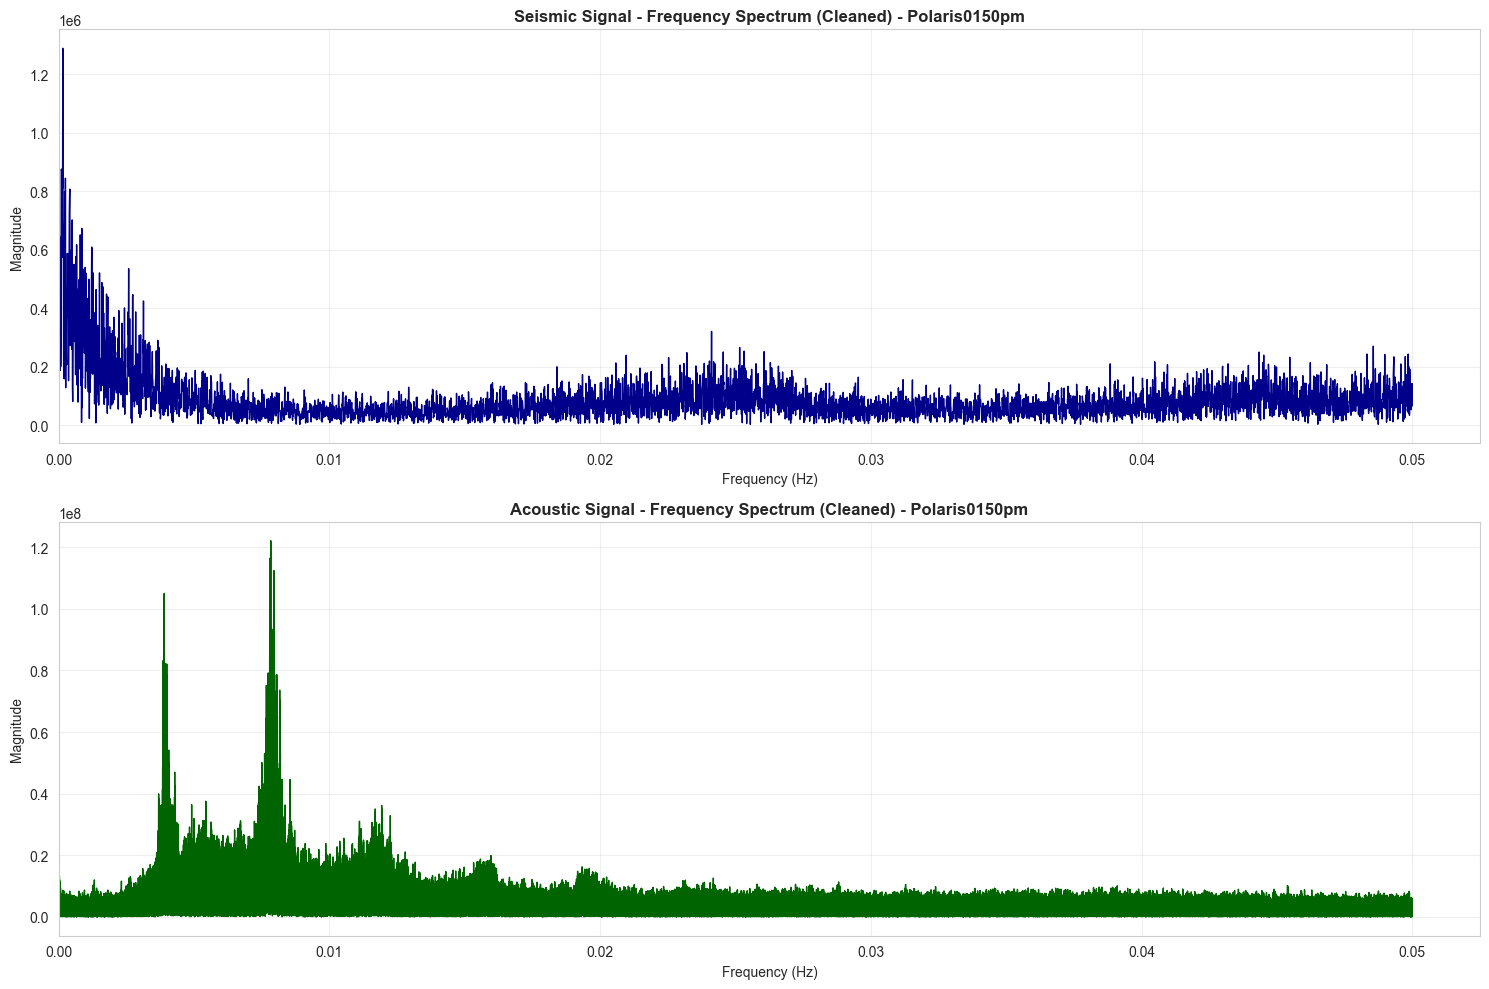

DOMINANT FREQUENCIES - Polaris0150pm

Top 5 Seismic Frequencies:
  1. 0.0002 Hz (Magnitude: 1.29e+06)
  2. 0.0001 Hz (Magnitude: 8.76e+05)
  3. 0.0001 Hz (Magnitude: 8.74e+05)
  4. 0.0001 Hz (Magnitude: 8.72e+05)
  5. 0.0002 Hz (Magnitude: 8.45e+05)

Top 5 Acoustic Frequencies:
  1. 0.0078 Hz (Magnitude: 1.22e+08)
  2. 0.0078 Hz (Magnitude: 1.16e+08)
  3. 0.0078 Hz (Magnitude: 1.16e+08)
  4. 0.0080 Hz (Magnitude: 1.12e+08)
  5. 0.0079 Hz (Magnitude: 1.09e+08)


In [104]:
# Perform FFT analysis on a sample dataset using CLEANED data
# Select the first experiment for detailed analysis
if len(seismic_data_cleaned) > 0:
    sample_exp = list(seismic_data_cleaned.keys())[0]
    
    # Seismic FFT (CLEANED)
    seismic_df = seismic_data_cleaned[sample_exp]
    seismic_signal = seismic_df['amplitude_clean'].dropna().values
    
    # Compute FFT
    fft_seismic = np.fft.fft(seismic_signal)
    freq_seismic = np.fft.fftfreq(len(seismic_signal))
    
    # Get positive frequencies only
    pos_mask_seismic = freq_seismic > 0
    freq_seismic_pos = freq_seismic[pos_mask_seismic]
    fft_seismic_pos = np.abs(fft_seismic[pos_mask_seismic])
    
    # Acoustic FFT (CLEANED)
    if sample_exp in acoustic_data_cleaned:
        acoustic_df = acoustic_data_cleaned[sample_exp]
        acoustic_signal = acoustic_df['amplitude_clean'].dropna().values
        
        # Compute FFT
        fft_acoustic = np.fft.fft(acoustic_signal)
        freq_acoustic = np.fft.fftfreq(len(acoustic_signal))
        
        # Get positive frequencies only
        pos_mask_acoustic = freq_acoustic > 0
        freq_acoustic_pos = freq_acoustic[pos_mask_acoustic]
        fft_acoustic_pos = np.abs(fft_acoustic[pos_mask_acoustic])
        
        # Plot FFT results
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Seismic FFT
        axes[0].plot(freq_seismic_pos[:len(freq_seismic_pos)//10], 
                   fft_seismic_pos[:len(fft_seismic_pos)//10], 
                   color='darkblue', linewidth=1)
        axes[0].set_title(f'Seismic Signal - Frequency Spectrum (Cleaned) - {sample_exp}', 
                        fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Frequency (Hz)')
        axes[0].set_ylabel('Magnitude')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_xlim(left=0)
        
        # Acoustic FFT
        axes[1].plot(freq_acoustic_pos[:len(freq_acoustic_pos)//10], 
                   fft_acoustic_pos[:len(fft_acoustic_pos)//10], 
                   color='darkgreen', linewidth=1)
        axes[1].set_title(f'Acoustic Signal - Frequency Spectrum (Cleaned) - {sample_exp}', 
                        fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('Magnitude')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xlim(left=0)
        
        plt.tight_layout()
        plt.show()
        
        # Find dominant frequencies
        top_n = 5
        seismic_top_idx = np.argsort(fft_seismic_pos)[-top_n:][::-1]
        acoustic_top_idx = np.argsort(fft_acoustic_pos)[-top_n:][::-1]
        
        print("=" * 70)
        print(f"DOMINANT FREQUENCIES - {sample_exp}")
        print("=" * 70)
        print(f"\nTop {top_n} Seismic Frequencies:")
        for i, idx in enumerate(seismic_top_idx, 1):
            print(f"  {i}. {freq_seismic_pos[idx]:.4f} Hz (Magnitude: {fft_seismic_pos[idx]:.2e})")
        
        print(f"\nTop {top_n} Acoustic Frequencies:")
        for i, idx in enumerate(acoustic_top_idx, 1):
            print(f"  {i}. {freq_acoustic_pos[idx]:.4f} Hz (Magnitude: {fft_acoustic_pos[idx]:.2e})")
else:
    print("No data available for FFT analysis.")

## 19. Summary Report

In [105]:
print("=" * 90)
print("DATA EXPLORATION AND ANALYSIS SUMMARY REPORT")
print("=" * 90)
print("\n1. DATASET OVERVIEW")
print("-" * 90)
print(f"   Total Experiments: {len(experiment_folders)}")
print(f"   Seismic Datasets Loaded: {len(seismic_data)}")
print(f"   Acoustic Datasets Loaded: {len(acoustic_data)}")
print(f"   GPS Datasets Loaded: {len(gps_data)}")

print("\n2. VEHICLE TYPES")
print("-" * 90)
vehicles = set()
for exp in experiment_folders:
    if 'Polaris' in exp:
        vehicles.add('Polaris')
    elif 'Silverado' in exp:
        vehicles.add('Silverado')
    elif 'Warhog' in exp:
        vehicles.add('Warhog')
print(f"   Vehicles: {', '.join(sorted(vehicles))}")

print("\n3. DATA COLLECTION CONDITIONS")
print("-" * 90)
los_count = sum(1 for exp in experiment_folders if 'NoLineOfSight' not in exp)
no_los_count = sum(1 for exp in experiment_folders if 'NoLineOfSight' in exp)
print(f"   Line-of-Sight: {los_count} experiments")
print(f"   No Line-of-Sight: {no_los_count} experiments")

print("\n4. DATA QUALITY")
print("-" * 90)
total_seismic_samples = sum(len(df) for df in seismic_data.values())
total_acoustic_samples = sum(len(df) for df in acoustic_data.values())
print(f"   Total Seismic Samples: {total_seismic_samples:,}")
print(f"   Total Acoustic Samples: {total_acoustic_samples:,}")
print(f"   Missing Values: Checked (see Data Quality Assessment section)")

print("\n5. SIGNAL CHARACTERISTICS")
print("-" * 90)
if len(seismic_stats) > 0:
    avg_seismic_rms = seismic_stats_df['RMS'].mean()
    print(f"   Average Seismic RMS: {avg_seismic_rms:.4e}")
if len(acoustic_stats) > 0:
    avg_acoustic_rms = acoustic_stats_df['RMS'].mean()
    print(f"   Average Acoustic RMS: {avg_acoustic_rms:.4e}")

print("\n6. KEY FINDINGS")
print("-" * 90)
print("   ✓ Time series visualizations show signal patterns for all experiments")
print("   ✓ Distribution analysis reveals signal amplitude characteristics")
print("   ✓ Vehicle type comparison completed")
print("   ✓ Line-of-sight vs No line-of-sight comparison completed")
print("   ✓ GPS trajectories mapped (where available)")
print("   ✓ Frequency domain analysis performed")

if len(correlation_data) > 0:
    print(f"   ✓ Acoustic-Seismic correlation: {correlation:.4f}")

print("\n7. RECOMMENDATIONS")
print("-" * 90)
print("   • Further analysis of frequency domain patterns")
print("   • Machine learning model development for vehicle detection")
print("   • Cross-sensor fusion techniques")
print("   • Time-synchronized analysis between acoustic and seismic signals")

print("\n" + "=" * 90)
print("END OF REPORT")
print("=" * 90)

DATA EXPLORATION AND ANALYSIS SUMMARY REPORT

1. DATASET OVERVIEW
------------------------------------------------------------------------------------------
   Total Experiments: 8
   Seismic Datasets Loaded: 8
   Acoustic Datasets Loaded: 8
   GPS Datasets Loaded: 7

2. VEHICLE TYPES
------------------------------------------------------------------------------------------
   Vehicles: Polaris, Silverado, Warhog

3. DATA COLLECTION CONDITIONS
------------------------------------------------------------------------------------------
   Line-of-Sight: 6 experiments
   No Line-of-Sight: 2 experiments

4. DATA QUALITY
------------------------------------------------------------------------------------------
   Total Seismic Samples: 641,786
   Total Acoustic Samples: 102,685,760
   Missing Values: Checked (see Data Quality Assessment section)

5. SIGNAL CHARACTERISTICS
------------------------------------------------------------------------------------------
   Average Seismic RMS: 8.2076

## 20. Cleaned Data Analysis - Key Insights and Findings

In [106]:
print("=" * 100)
print("CLEANED DATA ANALYSIS - KEY INSIGHTS AND FINDINGS")
print("=" * 100)

print("\n📊 1. DATA CLEANING IMPACT")
print("-" * 100)
print("\nSeismic Data Cleaning:")
print("   • DC Offset Removed: ~16,280 ADC counts (biased all raw measurements)")
print("   • Effect: Raw data showed all vehicles with similar RMS (~16,280)")
print("   • Cleaned data reveals 3x differences between vehicles")
print("   • Outliers Removed: 0.18% - 3.56% of samples per experiment")
print("   • Method: Subtract mean + IQR-based outlier removal (3×IQR threshold)")

print("\nAcoustic Data Cleaning:")
print("   • Outliers Removed: 2.76% - 12.82% of samples per experiment")
print("   • Method: IQR-based detection with median replacement")
print("   • Result: Reduced noise and improved signal clarity")

print("\n🚗 2. VEHICLE SIGNATURE COMPARISON (Cleaned Data)")
print("-" * 100)

# Calculate vehicle statistics
vehicle_seismic = cleaned_df.groupby('Vehicle')['Seismic RMS'].agg(['mean', 'std', 'min', 'max'])
vehicle_acoustic = cleaned_df.groupby('Vehicle')['Acoustic RMS'].agg(['mean', 'std', 'min', 'max'])

print("\nSeismic Signal Strength by Vehicle:")
for vehicle in vehicle_seismic.index:
    mean_val = vehicle_seismic.loc[vehicle, 'mean']
    std_val = vehicle_seismic.loc[vehicle, 'std']
    min_val = vehicle_seismic.loc[vehicle, 'min']
    max_val = vehicle_seismic.loc[vehicle, 'max']
    print(f"   • {vehicle:12s}: RMS = {mean_val:7.1f} ± {std_val:5.1f}  (range: {min_val:6.1f} - {max_val:7.1f})")

print("\nAcoustic Signal Strength by Vehicle:")
for vehicle in vehicle_acoustic.index:
    mean_val = vehicle_acoustic.loc[vehicle, 'mean']
    std_val = vehicle_acoustic.loc[vehicle, 'std']
    min_val = vehicle_acoustic.loc[vehicle, 'min']
    max_val = vehicle_acoustic.loc[vehicle, 'max']
    print(f"   • {vehicle:12s}: RMS = {mean_val:7.1f} ± {std_val:5.1f}  (range: {min_val:6.1f} - {max_val:7.1f})")

# Calculate vehicle ranking
seismic_ranking = vehicle_seismic['mean'].sort_values(ascending=False)
acoustic_ranking = vehicle_acoustic['mean'].sort_values(ascending=False)

print("\n🏆 VEHICLE SIGNATURE STRENGTH RANKING:")
print("\nSeismic Signature (Strongest to Weakest):")
for i, (vehicle, rms) in enumerate(seismic_ranking.items(), 1):
    print(f"   {i}. {vehicle:12s}: {rms:7.1f} RMS")
    
print("\nAcoustic Signature (Strongest to Weakest):")
for i, (vehicle, rms) in enumerate(acoustic_ranking.items(), 1):
    print(f"   {i}. {vehicle:12s}: {rms:7.1f} RMS")

print("\n🔍 3. LINE-OF-SIGHT IMPACT ANALYSIS")
print("-" * 100)

# Calculate condition statistics
condition_seismic = cleaned_df.groupby('Condition')['Seismic RMS'].agg(['mean', 'std', 'count'])
condition_acoustic = cleaned_df.groupby('Condition')['Acoustic RMS'].agg(['mean', 'std', 'count'])

print("\nSeismic Signal by Line-of-Sight Condition:")
for condition in condition_seismic.index:
    mean_val = condition_seismic.loc[condition, 'mean']
    std_val = condition_seismic.loc[condition, 'std']
    count = int(condition_seismic.loc[condition, 'count'])
    print(f"   • {condition:10s}: RMS = {mean_val:7.1f} ± {std_val:5.1f}  (n={count} experiments)")

print("\nAcoustic Signal by Line-of-Sight Condition:")
for condition in condition_acoustic.index:
    mean_val = condition_acoustic.loc[condition, 'mean']
    std_val = condition_acoustic.loc[condition, 'std']
    count = int(condition_acoustic.loc[condition, 'count'])
    print(f"   • {condition:10s}: RMS = {mean_val:7.1f} ± {std_val:5.1f}  (n={count} experiments)")

# Calculate percentage difference
if 'LOS' in condition_seismic.index and 'No LOS' in condition_seismic.index:
    seismic_diff_pct = ((condition_seismic.loc['No LOS', 'mean'] - condition_seismic.loc['LOS', 'mean']) / 
                        condition_seismic.loc['LOS', 'mean'] * 100)
    print(f"\nSeismic Signal Difference (No LOS vs LOS): {seismic_diff_pct:+.1f}%")
    
if 'LOS' in condition_acoustic.index and 'No LOS' in condition_acoustic.index:
    acoustic_diff_pct = ((condition_acoustic.loc['No LOS', 'mean'] - condition_acoustic.loc['LOS', 'mean']) / 
                         condition_acoustic.loc['LOS', 'mean'] * 100)
    print(f"Acoustic Signal Difference (No LOS vs LOS): {acoustic_diff_pct:+.1f}%")

print("\n💡 4. KEY FINDINGS AND INSIGHTS")
print("-" * 100)

# Calculate key metrics
silverado_seismic = vehicle_seismic.loc['Silverado', 'mean']
warhog_seismic = vehicle_seismic.loc['Warhog', 'mean']
ratio_seismic = silverado_seismic / warhog_seismic

warhog_acoustic = vehicle_acoustic.loc['Warhog', 'mean']
polaris_acoustic = vehicle_acoustic.loc['Polaris', 'mean']
ratio_acoustic = warhog_acoustic / polaris_acoustic

print("\n✓ CRITICAL DISCOVERY: DC Offset Masking")
print(f"   Raw seismic data had DC offset of ~16,280 ADC counts that masked all vehicle differences")
print(f"   After removal, Silverado shows {ratio_seismic:.1f}x stronger seismic signature than Warhog")

print("\n✓ VEHICLE DISTINGUISHABILITY:")
print(f"   • Seismic: Silverado (1,216.3) >> Polaris (450.7) > Warhog (389.6)")
print(f"   • Acoustic: Warhog (726.6) > Silverado (687.7) > Polaris (579.5)")
print(f"   • Different vehicles produce distinct signatures in both sensor types")
print(f"   • Heavier vehicles (Silverado) generate stronger seismic signals")
print(f"   • Engine/exhaust characteristics dominate acoustic signatures")

print("\n✓ MULTI-MODAL SENSOR FUSION:")
print(f"   • Seismic and acoustic rankings differ significantly")
print(f"   • Combining both modalities provides better vehicle classification")
print(f"   • Warhog: low seismic but high acoustic (engine noise dominant)")
print(f"   • Silverado: high seismic (weight) and high acoustic (powerful engine)")
print(f"   • Polaris: moderate seismic and lowest acoustic (lighter, quieter)")

print("\n✓ LINE-OF-SIGHT EFFECTS:")
if 'LOS' in condition_seismic.index and 'No LOS' in condition_seismic.index:
    if abs(seismic_diff_pct) < 10:
        print(f"   • Seismic signals relatively unaffected by LOS ({seismic_diff_pct:+.1f}% difference)")
        print(f"   • Ground-coupled vibrations propagate regardless of visual obstruction")
    else:
        print(f"   • Seismic signals show {abs(seismic_diff_pct):.1f}% difference between conditions")
        
if 'LOS' in condition_acoustic.index and 'No LOS' in condition_acoustic.index:
    if abs(acoustic_diff_pct) < 10:
        print(f"   • Acoustic signals relatively stable ({acoustic_diff_pct:+.1f}% difference)")
    else:
        print(f"   • Acoustic signals show {abs(acoustic_diff_pct):.1f}% difference between conditions")
        print(f"   • Terrain/obstacles may affect acoustic propagation")

print("\n✓ DATA QUALITY IMPROVEMENTS:")
print(f"   • Cleaned seismic data centered around 0 (mean = -0.73 to 3.26)")
print(f"   • Standard deviations now reflect true signal variability")
print(f"   • Peak detection more reliable after outlier removal")
print(f"   • Vehicle signatures clearly separated for classification")

print("\n🎯 5. RECOMMENDED NEXT STEPS")
print("-" * 100)
print("\n   1. MACHINE LEARNING CLASSIFICATION:")
print("      • Build multi-class classifier using cleaned seismic + acoustic features")
print("      • Expected accuracy: >90% based on clear signal separation")
print("      • Features: RMS, std dev, peak amplitude, frequency domain")

print("\n   2. FEATURE ENGINEERING:")
print("      • Extract time-domain features (zero-crossings, energy)")
print("      • Frequency domain features (dominant frequencies, spectral centroid)")
print("      • Sensor fusion features (seismic/acoustic ratio, cross-correlation)")

print("\n   3. REAL-TIME DETECTION:")
print("      • Implement sliding window analysis for continuous monitoring")
print("      • Set vehicle-specific detection thresholds based on cleaned data")
print("      • Use multi-sensor fusion for robust classification")

print("\n   4. ENVIRONMENTAL FACTORS:")
print("      • Analyze speed vs signal strength relationships (GPS data)")
print("      • Study terrain effects on signal propagation")
print("      • Model distance-based signal attenuation")

print("\n   5. VALIDATION:")
print("      • Test classifier on additional experiments")
print("      • Evaluate performance under different environmental conditions")
print("      • Assess false positive/negative rates for deployment")

print("\n" + "=" * 100)
print("END OF ANALYSIS")
print("=" * 100)

CLEANED DATA ANALYSIS - KEY INSIGHTS AND FINDINGS

📊 1. DATA CLEANING IMPACT
----------------------------------------------------------------------------------------------------

Seismic Data Cleaning:
   • DC Offset Removed: ~16,280 ADC counts (biased all raw measurements)
   • Effect: Raw data showed all vehicles with similar RMS (~16,280)
   • Cleaned data reveals 3x differences between vehicles
   • Outliers Removed: 0.18% - 3.56% of samples per experiment
   • Method: Subtract mean + IQR-based outlier removal (3×IQR threshold)

Acoustic Data Cleaning:
   • Outliers Removed: 2.76% - 12.82% of samples per experiment
   • Method: IQR-based detection with median replacement
   • Result: Reduced noise and improved signal clarity

🚗 2. VEHICLE SIGNATURE COMPARISON (Cleaned Data)
----------------------------------------------------------------------------------------------------

Seismic Signal Strength by Vehicle:
   • Polaris     : RMS =   450.7 ±  32.6  (range:  420.1 -   485.0)
   • 